# Building and visualizing conceptograms

## Imports

In [ ]:
import sys
sys.path.insert(0, '/home/liviamanovi/gitty/peepholelib') # adapt to your case

In [ ]:
%matplotlib widget

In [ ]:
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 
from peepholelib.coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from peepholelib.classifier.classifier_base import trim_corevectors#, map_labels
from peepholelib.classifier.tkmeans import KMeans as tKMeans 
from peepholelib.classifier.tgmm import GMM as tGMM 
from peepholelib.peepholes.peepholes import Peepholes
from peepholelib.utils.testing import trim_dataloaders

In [ ]:
from nb_utils import *

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device('cpu')
print(f'Using {device} device')

## Directories and definitions

In [ ]:
base_dir = Path('/srv/newpenny/XAI/generated_data') # adapt to your case

### Dataset

In [ ]:
dataset = 'CIFAR100'
ds_path = f'/srv/newpenny/dataset/{dataset}'

In [ ]:
verbose = True

# pretrained = True
seed = 29
bs = 64

ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = 256, # bs
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

### Model

In [9]:
# pretrained = True
# seed = 29
# bs = 64
model_id = 'vgg16'
model_dir = '/srv/newpenny/XAI/models'
with open(Path(model_dir)/'model_config.pkl', 'rb') as f:
    model_config = pickle.load(f)

model_name = model_config[model_id][dataset]

These are the layers that compose the conceptograms, to which we may or may not add the softmax output of the DNN:

In [10]:
# vgg16
target_layers = [
    'features.24', 
    'features.26', 
    'features.28', 
    'classifier.0', 
    'classifier.3'
]

In [11]:
# if model_id=='vgg16':
nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
n_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, n_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=False)
model.set_target_layers(target_layers=target_layers, verbose=verbose)

### Corevectors and labels

In [12]:
# adapt to your case
cvs_name = 'corevectors'
cvs_path = Path(base_dir)/f'corevectors/{dataset}/{model_id}'

In [13]:
cv_dict = {}
result = {}
pred = {}
true = {}

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )

    cv_dl = cv.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

    for split in ['train', 'test', 'val']:
        result[split] = cv_dl[split].dataset['result'].detach().cpu().numpy()
        pred[split] = cv_dl[split].dataset['pred'].detach().cpu().numpy()
        true[split] = cv_dl[split].dataset['label'].detach().cpu().numpy()
    
        cv_dict[split] = cv_dl[split].dataset['coreVectors'].detach().cpu().numpy()


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
closing train
closing test
closing val


## NN Outputs
Here you can collect the outputs of your NN and store its evaluation results into a dict made of `pd.DataFrame`.

In [14]:
sd = model._checkpoint['state_dict']
nn_ = nn
nn_.state_dict = sd
nn_.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
splits = ['val', 'test'] # ['train', 'val', 'test']

#### Compute

In [19]:
o_dnn = {} # structure to store DNN outputs (you will need them for the conceptograms)
o_dnn_dfs = {} # here you can store pd.DataFrame to evaluate the NN

for split in splits:
    if split=='train':
        data_loader = ds.get_train_dataset()
    elif split=='val':
        data_loader = ds.get_val_dataset()
    elif split=='test':
        data_loader = ds.get_test_dataset()

    outputs_ = []
    
    correct_predictions = 0
    total_predictions = 0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            true_labels.append(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = nn_(inputs)
            outputs_.append(outputs)
    
            _, predicted = torch.max(outputs, 1)
            pred_labels.append(predicted.cpu())
            
            correct_predictions += accuracy(outputs, targets) * targets.size(0)
            total_predictions += targets.size(0)
    
    outputs = torch.nn.functional.softmax(torch.cat(outputs_), dim=1)
    outputs = outputs.detach().cpu().numpy()

    o_dnn[split] = outputs # output collection

    # output processing
    pred_labels = torch.concatenate(pred_labels)
    true_labels = torch.concatenate(true_labels)
    r = pred_labels==true_labels

    out_max = np.max(outputs, axis=1)
    out_label = np.argmax(outputs, axis=1)

    out_df = pd.DataFrame()
    out_df['max'] = out_max
    out_df['entropy'] = [1 - normalized_entropy(out, adjusted=False) for out in outputs]
    out_df['label'] = out_label
    out_df['true'] = true_labels #true
    out_df['true'] = out_df['true'].astype(int)
    out_df['result'] = r

    o_dnn_dfs[split] = out_df # performance results collection

  0%|                                                    | 0/40 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.06 GiB. GPU 0 has a total capacity of 39.39 GiB of which 464.81 MiB is free. Process 4157880 has 34.08 GiB memory in use. Including non-PyTorch memory, this process has 4.85 GiB memory in use. Of the allocated memory 4.36 GiB is allocated by PyTorch, and 5.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Load

In [17]:
splits = ['val', 'test'] # ['train', 'val', 'test']

In [18]:
bc_res = Path(base_dir) / 'binary_classifier'

In [19]:
with open(Path(bc_res) / f'full_dnn_performance_{dataset}.pkl', 'rb') as f:
    o_dnn_dfs = pickle.load(f)

In [20]:
with open(Path(bc_res) / f'test_cgs-with-o_dnn_{dataset}.pkl', 'rb') as f:
    x = pickle.load(f)

o_dnn = {}
for split in splits:
    o_dnn[split] = x[split][:, :, -1]

## Load peepholes

TODO: check paths and use naming conventions and don't use a billion paths 

In [21]:
results_dir = Path(base_dir) / f'results_{dataset}_{model_id}' # use a directory to store results
results_dir.mkdir(parents=True, exist_ok=True)

### All configurations

In [22]:
cls_type = 'tKMeans' # 'tGMM' or the classifier you used to generate peepholes

In [23]:
splits = ['val', 'test'] #['train', 'test', 'val']

phs_path = Path(base_dir)/f'peepholes/{dataset}/{model_id}/{cls_type}' 
    
entries = phs_path.iterdir()
config_names = {'.'.join(entry.name.split('.')[:-1]) for entry in entries}
if '' in config_names: config_names.discard('')

# load scores
ph_dict = {}
for ph_config_name in config_names:
    peepholes = Peepholes(
        path=phs_path,
        name=ph_config_name,
        classifier=None,
        layer=target_layers,
        device=device
    )
    with peepholes as ph:
        ph.load_only(loaders=splits, verbose=False)
        for split in splits:
            ph_dict.setdefault(ph_config_name, {})[split] = ph._phs[split].detach().cpu().numpy()

closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test
closing val
closing test


### Tuning

__How to select a configuration?__


#### Accuracy based 
One possible criterion is to evaluate each single layer so that we reject the least possible number of inputs to reach a target accuracy.
We can store information about the relative `(peep_size, n_clusters)` in a `pd.DataFrame` to automate the selection of peephole from the above `ph_dict`.

In [21]:
sm = {}
se = {}
delta = 0.02 # target increase in accuracy

for ph_config_name in set(config_names):
    sm[ph_config_name] = {}
    se[ph_config_name] = {}

    for split in splits:
        sm[ph_config_name][split] = {}
        se[ph_config_name][split] = {}

        for layer in target_layers:
            if layer not in ph_dict[ph_config_name][split] or layer not in ph_dict[ph_config_name][split].keys():
                #print(f'Skipping missing layer: {layer} for config {ph_config_name}')
                continue
            else:
                sm[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_max']
                se[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_entropy']

In [24]:
res_name = f'results_tuning_{cls_type}.csv'
results_path = results_dir / res_name

# check if the tuning results file already exists
if results_path.exists():
    print(f'Results file {res_name} already exists. Loading existing results.')
    results_df = pd.read_csv(results_path)
else:
    results = []

    # loop over score types ('max', 'entropy') for evaluation
    for score_type in ['max', 'entropy']:
        split = 'val'
        out_df = o_dnn_dfs['val']

        # initialize dictionaries to store evaluation results
        eval_max = {}
        eval_entropy = {}

        # iterate over unique configurations
        for i, ph_config_name in enumerate(set(config_names)):
            peep_size = ph_config_name.split('.')[1]
            n_cls = ph_config_name.split('.')[2]

            # evaluate for each target layer
            for j, layer in enumerate(target_layers):
                if layer not in sm[ph_config_name][split] or layer not in se[ph_config_name][split]:
                    continue
                
                # get data based on score type
                if score_type == 'max':
                    data = sm[ph_config_name][split][layer]
                else:
                    data = se[ph_config_name][split][layer]
                
                # skip if data contains only NaN values
                if np.isnan(data).all():
                    continue

                # create a DataFrame for evaluation
                df_eval = pd.DataFrame()
                df_eval[score_type] = data
                df_eval['result'] = out_df['result'].values
                df_sorted = df_eval.sort_values(by=score_type, ascending=False)

                # calculate initial accuracy and target accuracy
                acc_ini = df_sorted['result'].sum() / len(df_sorted)
                target_acc = acc_ini + delta*acc_ini  # `delta` is predefined
                num_to_remove = eval_acc(df_sorted, target_acc)  # `eval_acc` is a function in `nb_utils.py`

                # store evaluation result based on score type
                if score_type == 'max':
                    eval_max[(peep_size, n_cls, layer)] = num_to_remove
                else:
                    eval_entropy[(peep_size, n_cls, layer)] = num_to_remove

        # select the appropriate dictionary for results
        if score_type == 'max':
            res_dict = eval_max
        else:
            res_dict = eval_entropy

        # convert the results to a DataFrame
        df = pd.DataFrame(
            list(res_dict.items()),
            columns=['config', 'num_to_remove']
        )

        # split the 'config' column into separate columns for peep_size, n_cls, and layer
        df[['peep_size', 'n_cls', 'layer']] = pd.DataFrame(df['config'].tolist(), index=df.index)
        df = df.drop(columns=['config'])
        df = df.set_index(['peep_size', 'n_cls', 'layer'])

        print(f'score_type: {score_type} - cls: {cls_type}')

        # evaluate results for each layer
        for layer in target_layers:
            layer_df = df.xs(layer, level='layer')

            # define output path for each layer's results
            layer_output_path = results_dir / f'eval_{cls_type}_{score_type}_layer_{layer}.csv'
            layer_df.to_csv(layer_output_path)

            # find the configuration with the minimum 'num_to_remove' value
            min_config = layer_df['num_to_remove'].idxmin()
            min_value = layer_df['num_to_remove'].min()

            # calculate the percentage of elements removed
            percent_removed = min_value / len(out_df['result'].values)

            # append the results for later use
            results.append({
                'score_type': score_type,
                'cls_type': cls_type,
                'layer': layer,
                'best_config': min_config,
                'percent_removed': percent_removed
            })

    # convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # save the final results DataFrame to a CSV file
    results_df.to_csv(results_path, index=False)

    print(f'Results saved to {results_path}.')

Results file results_tuning_tKMeans.csv already exists. Loading existing results.


In [25]:
results_df.style.background_gradient(subset=['percent_removed'], cmap='viridis')

#### Correlation based 
__Why Use Correlation for Tuning?__
* The __core vector__ is a low-dimensional summary of activations. If it __retains meaningful structure__, it should correlate __strongly__ with the final DNN logits or softmax outputs.
* The __number of clusters__ affects how __decision-related information is grouped__. If clustering is too fine or too coarse, important relationships could be lost.
* Maximizing the correlation with the __correct decision logits/softmax outputs__ ensures that the peephole representation __aligns with the DNN's decision confidence__.

In [55]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

def compute_correlation(peepholes, logits):
    '''Computes Pearson and Spearman correlation between peepholes and DNN outputs.'''
    pearson_corr, _ = pearsonr(peepholes.flatten(), logits.flatten())
    spearman_corr, _ = spearmanr(peepholes.flatten(), logits.flatten())
    
    return pearson_corr, spearman_corr

def compute_mutual_information(peepholes, logits):
    '''Computes Mutual Information between peepholes and logits.'''
    mi_scores = mutual_info_regression(peepholes, logits)
    return np.mean(mi_scores)  # Average MI across dimensions

In [58]:
# delta = 0.02  # target increase in accuracy

corr_results = {}  # store correlation scores

for ph_config_name in set(config_names):
    corr_results[ph_config_name] = {}

    for split in splits:
        if split not in o_dnn:
            continue  # skip if DNN outputs are missing for this split

        corr_results[ph_config_name][split] = {}

        for layer in target_layers:
            if layer not in ph_dict[ph_config_name][split]:
                continue  # skip if the layer is missing

            # extract peepholes
            peepholes = ph_dict[ph_config_name][split][layer]['peepholes']

            # extract corresponding DNN outputs (logits or softmax)
            dnn_outputs = o_dnn[split]  # assume this contains logits/softmax per sample

            # ensure peepholes and DNN outputs are aligned
            if len(peepholes) != len(dnn_outputs):
                print(f'Mismatch in sample size for {ph_config_name} - {layer}, skipping.')
                continue

            # compute correlation scores
            pearson_corr, _ = pearsonr(peepholes.flatten(), dnn_outputs.flatten())
            spearman_corr, _ = spearmanr(peepholes.flatten(), dnn_outputs.flatten())
            #mutual_info = np.mean(mutual_info_regression(peepholes, dnn_outputs))  # average MI

            # store correlations
            corr_results[ph_config_name][split][layer] = {
                'pearson_corr': pearson_corr,
                'spearman_corr': spearman_corr,
                #'mutual_info': mutual_info
            }

In [59]:
# convert correlation results to DataFrame for analysis
corr_list = []

for ph_config_name, split_data in corr_results.items():
    k, C = ph_config_name.split('.')[1], ph_config_name.split('.')[2]  # extract k and C from name

    for split, layer_data in split_data.items():
        for layer, scores in layer_data.items():
            corr_list.append({
                'k': int(k),
                'C': int(C),
                'split': split,
                'layer': layer,
                'pearson_corr': scores['pearson_corr'],
                'spearman_corr': scores['spearman_corr'],
                #'mutual_info': scores['mutual_info']
            })

# convert to DataFrame for selection
corr_df = pd.DataFrame(corr_list)

In [60]:
corr_df

k    C split         layer  pearson_corr  spearman_corr
0     16   16   val   features.28      0.080555       0.113901
1     16   16   val  classifier.0      0.233811       0.323451
2     16   16   val  classifier.3      0.235517       0.328623
3     16   16  test   features.28      0.090397       0.113238
4     16   16  test  classifier.0      0.241082       0.314485
..   ...  ...   ...           ...           ...            ...
205  128  512  test   features.24      0.314936       0.305783
206  128  512  test   features.26      0.320467       0.319697
207  128  512  test   features.28      0.347712       0.344017
208  128  512  test  classifier.0      0.665057       0.620036
209  128  512  test  classifier.3      0.679925       0.672552

[210 rows x 6 columns]

In [61]:
best_configs = corr_df.groupby('layer')[['k', 'C', 'pearson_corr']].max().reset_index()
best_configs

layer    k    C  pearson_corr
0  classifier.0  300  512      0.696245
1  classifier.3  300  512      0.736362
2   features.24  256  512      0.343565
3   features.26  256  512      0.353178
4   features.28  300  512      0.463513

In [ ]:
# Save results for future analysis
results_path = results_dir / 'correlation_tuning_results.csv'
corr_df.to_csv(results_path, index=False)
print(f'Correlation tuning results saved to {results_path}.')

# Find the best (k, C) for each layer based on highest correlation
best_configs = corr_df.groupby('layer')[['k', 'C', 'pearson_corr']].max().reset_index()

# Print final selection
print('Best Configurations per Layer:')
print(best_configs)

In [ ]:
def select_best_k_C_adaptive(corr_df, lambda_factor=1.0):
    '''
    Selects the best (k, C) configuration per layer using an adaptive threshold.
    '''
    best_configs = []

    for layer in corr_df['layer'].unique():
        layer_df = corr_df[corr_df['layer'] == layer]
        mean_corr = layer_df['pearson_corr'].mean()
        std_corr = layer_df['pearson_corr'].std()
        threshold = mean_corr + lambda_factor * std_corr

        # Select configurations exceeding threshold
        best_layer_configs = layer_df[layer_df['pearson_corr'] >= threshold]
        best_configs.append(best_layer_configs)

    return pd.concat(best_configs)

# Example usage
best_configs_df = select_best_k_C_adaptive(corr_df, lambda_factor=1.0)
best_configs_df.to_csv(results_dir / 'adaptive_selected_configs.csv', index=False)


#### Additional Criteria:

* __Intra-Class Consistency__: You can also measure the variance within class-specific peepholes. A lower intra-class variance (or higher inter-class separability) indicates better configuration.
* __Adaptive Thresholds__: Set thresholds per layer based on the distribution of correlation values (for instance, configurations that exceed a dynamically set threshold based on mean and standard deviation of correlation across configurations).

### Custom configurations
If you just want to make some trials... you can skip tuning and do something like this:

In [131]:
n_layers = len(target_layers)

score_type_values = ['max'] * n_layers # assuming score_type is the same for all rows
cls_type_values = ['tKMeans'] * n_layers  # assuming cls_type is the same for all rows
layer_values = target_layers # or a subset of layers of your interest

best_config_values = [('64', '512'), ('64', '512'), ('300', '512'), ('256', '512'), ('256', '256')] # hard coded
# or randomly selected from the available configurations
unique_configs = set((ph_config_name.split('.')[1], ph_config_name.split('.')[2]) for ph_config_name in config_names)
selected_configs = random.sample(list(unique_configs), n_layers)
best_config_values = [tuple(config) for config in selected_configs]

In [134]:
custom_df = pd.DataFrame({
    'score_type': score_type_values,
    'cls_type': cls_type_values,
    'layer': layer_values,
    'best_config': best_config_values
})

custom_df

score_type cls_type         layer best_config
0        max  tKMeans   features.24   (16, 128)
1        max  tKMeans   features.26   (32, 256)
2        max  tKMeans   features.28    (16, 16)
3        max  tKMeans  classifier.0  (256, 100)
4        max  tKMeans  classifier.3  (128, 128)

### Peephole Selection

#### Utils

In [26]:
#import ast

def collect_ph_sel(ph_dict, results_df, split):
    ph_sel = {}
    
    for _, row in results_df.iterrows():
        score_type = row['score_type']
        cls_type = row['cls_type']
        layer = row['layer']
        
        # check if 'best_config' is a string and use literal_eval only if it is
        best_config = row['best_config']
        if isinstance(best_config, str):
            peep_size, n_cls = ast.literal_eval(best_config)
        else:
            peep_size, n_cls = best_config  # assuming it's already a tuple or list

        # initialize nested dictionary structure if needed
        if score_type not in ph_sel:
            ph_sel[score_type] = {}
        if cls_type not in ph_sel[score_type]:
            ph_sel[score_type][cls_type] = {}
        
        # construct the configuration name and retrieve data
        ph_config_name = f'peepholes.{peep_size}.{n_cls}'
        data = ph_dict[ph_config_name][split][layer]['peepholes']
        
        # store the data in the dictionary
        ph_sel[score_type][cls_type][layer] = data

    return ph_sel


In [27]:
# can be useful if you want to build a DataLoader of conceptograms
class PhDataset(Dataset):
    def __init__(self, data, labels):
        '''
        Args:
            data (numpy array): Array of shape (num_samples, height, width).
            labels (numpy array): Binary labels of shape (num_samples,).
        '''
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

#### Selection
Here you can use the `results_df` that is based on tuning or your `custom_df`.

In [28]:
#ph_sel_train = collect_ph_sel(ph_dict, results_df, 'train')
ph_sel_val = collect_ph_sel(ph_dict, results_df, 'val')
ph_sel_test = collect_ph_sel(ph_dict, results_df, 'test')

## Conceptograms

In [29]:
#ph_sel_dicts = {'train': ph_sel_train, 'val': ph_sel_val, 'test': ph_sel_test}
ph_sel_dicts = {'val': ph_sel_val, 'test': ph_sel_test}
ds_len = {'train': 40000, 'val': 10000, 'test': 10000}
score_type = 'max'

include_o_dnn = False # choose whether to include the output of the NN in the conceptograms

cgs = {}

for split, ph_sel in ph_sel_dicts.items():

    conceptograms = [] # peepholes only
    
    for i in range(ds_len[split]):
        ph_comb = []
        for layer in target_layers:
            ph = ph_sel[score_type][cls_type][layer][i]
            ph_comb.append(ph)
                
        cg = np.concatenate([ph_comb], axis=1).T
        if split != 'train':
            if include_o_dnn:
                ph_wdnn = np.concatenate([cg, o_dnn[split][i].reshape(-1, 1)], axis=1)
                conceptograms.append(ph_wdnn)
            else:
                conceptograms.append(cg)
    
    conceptograms = np.array(conceptograms)

    cgs[split] = conceptograms

In [30]:
cgs['val'][0].shape

(100, 5)

### Visualization

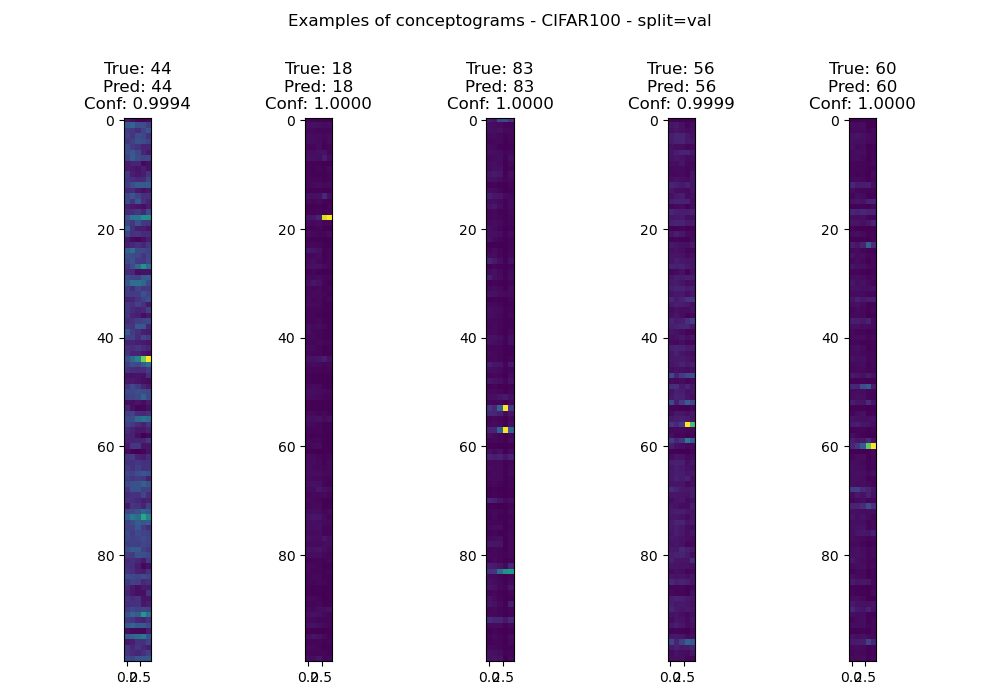

In [31]:
split = 'val'

n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(10, 7))
fig.suptitle(f'Examples of conceptograms - {dataset} - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs[split][i])
    axs[i].set_title(f'True: {int(true[split][i])}\nPred: {int(pred[split][i])}\nConf: {o_dnn_dfs[split]['max'][i]:.4f}')

plt.tight_layout()

In [32]:
classes = ds.get_classes()

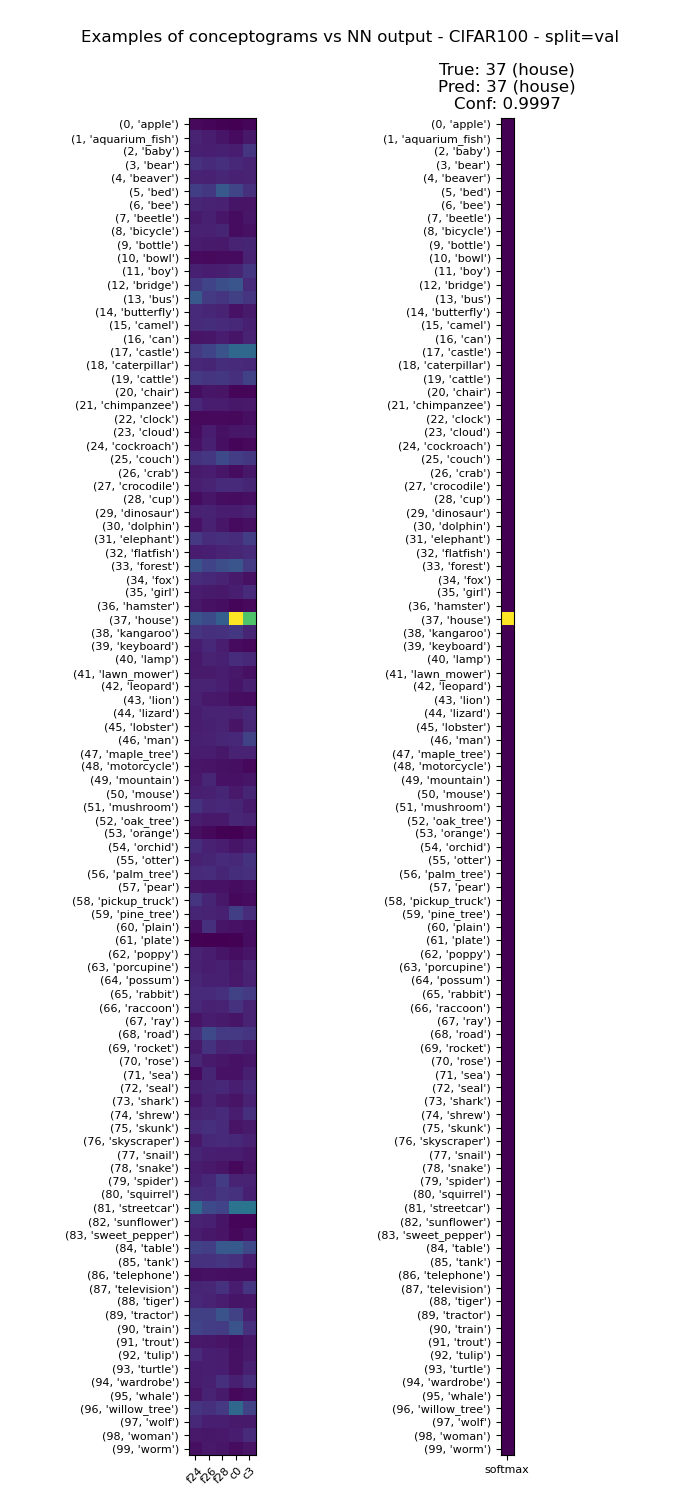

In [31]:
split = 'val'

idx = 50

x_labels = ['f24', 'f26', 'f28', 'c0', 'c3']
y_labels = list(ds.get_classes().keys())

fig, axs = plt.subplots(1, 2, figsize=(7, 15))
fig.suptitle(f'Examples of conceptograms vs NN output - {dataset} - split={split}\n')

axs[0].imshow(cgs[split][idx])

true_l = int(true[split][idx])
pred_l = int(pred[split][idx])
conf = o_dnn_dfs[split]['max'][idx]
axs[1].set_title(f'True: {true_l} ({classes[true_l]})\nPred: {pred_l} ({classes[pred_l]})\nConf: {conf:.4f}')
axs[1].imshow(o_dnn[split][idx].reshape(-1, 1))

axs[0].set_xticks(range(len(x_labels)))
axs[0].set_xticklabels(x_labels, fontsize=8, rotation=45)
axs[0].set_yticks(y_labels)
axs[0].set_yticklabels(list(classes.items()), fontsize=8)

axs[1].set_xticks([0])
axs[1].set_xticklabels(['softmax'], fontsize=8)
axs[1].set_yticks(y_labels)
axs[1].set_yticklabels(list(classes.items()), fontsize=8)

plt.tight_layout()

### Confidence Estimation

#### Prototype-based

__Concept:__ \
For each class, you can compute a “prototype” conceptogram by averaging the conceptograms (i.e., the fused representations across layers) of correctly classified training samples. The idea is that these prototypes capture the “ideal” or typical internal decision pathway for each class.

In [34]:
from scipy.spatial.distance import euclidean, mahalanobis
from scipy.stats import entropy

__1. Compute Class Prototypes__

In [35]:
out_df = o_dnn_dfs['val']

tl = out_df['true'].values
r = out_df['result'].values

In [36]:
P = {} # prototypes
n_classes = len(classes)
n_layers = len(target_layers)

for c in range(n_classes):
    idx = np.where((tl==c) & (r==True))
    if len(idx) > 0:
        P[c] = np.mean(cgs['val'][idx], axis=0)
    else:
        P[c] = np.zeros((n_classes, n_layers))
    

In [38]:
# fig, axs = plt.subplots(10, 10, figsize=(10, 40), sharex=True, sharey=True)
# for c, ax in enumerate(axs.ravel()):
#     ax.imshow(P[c])
# 
# plt.tight_layout()
# plt.show()

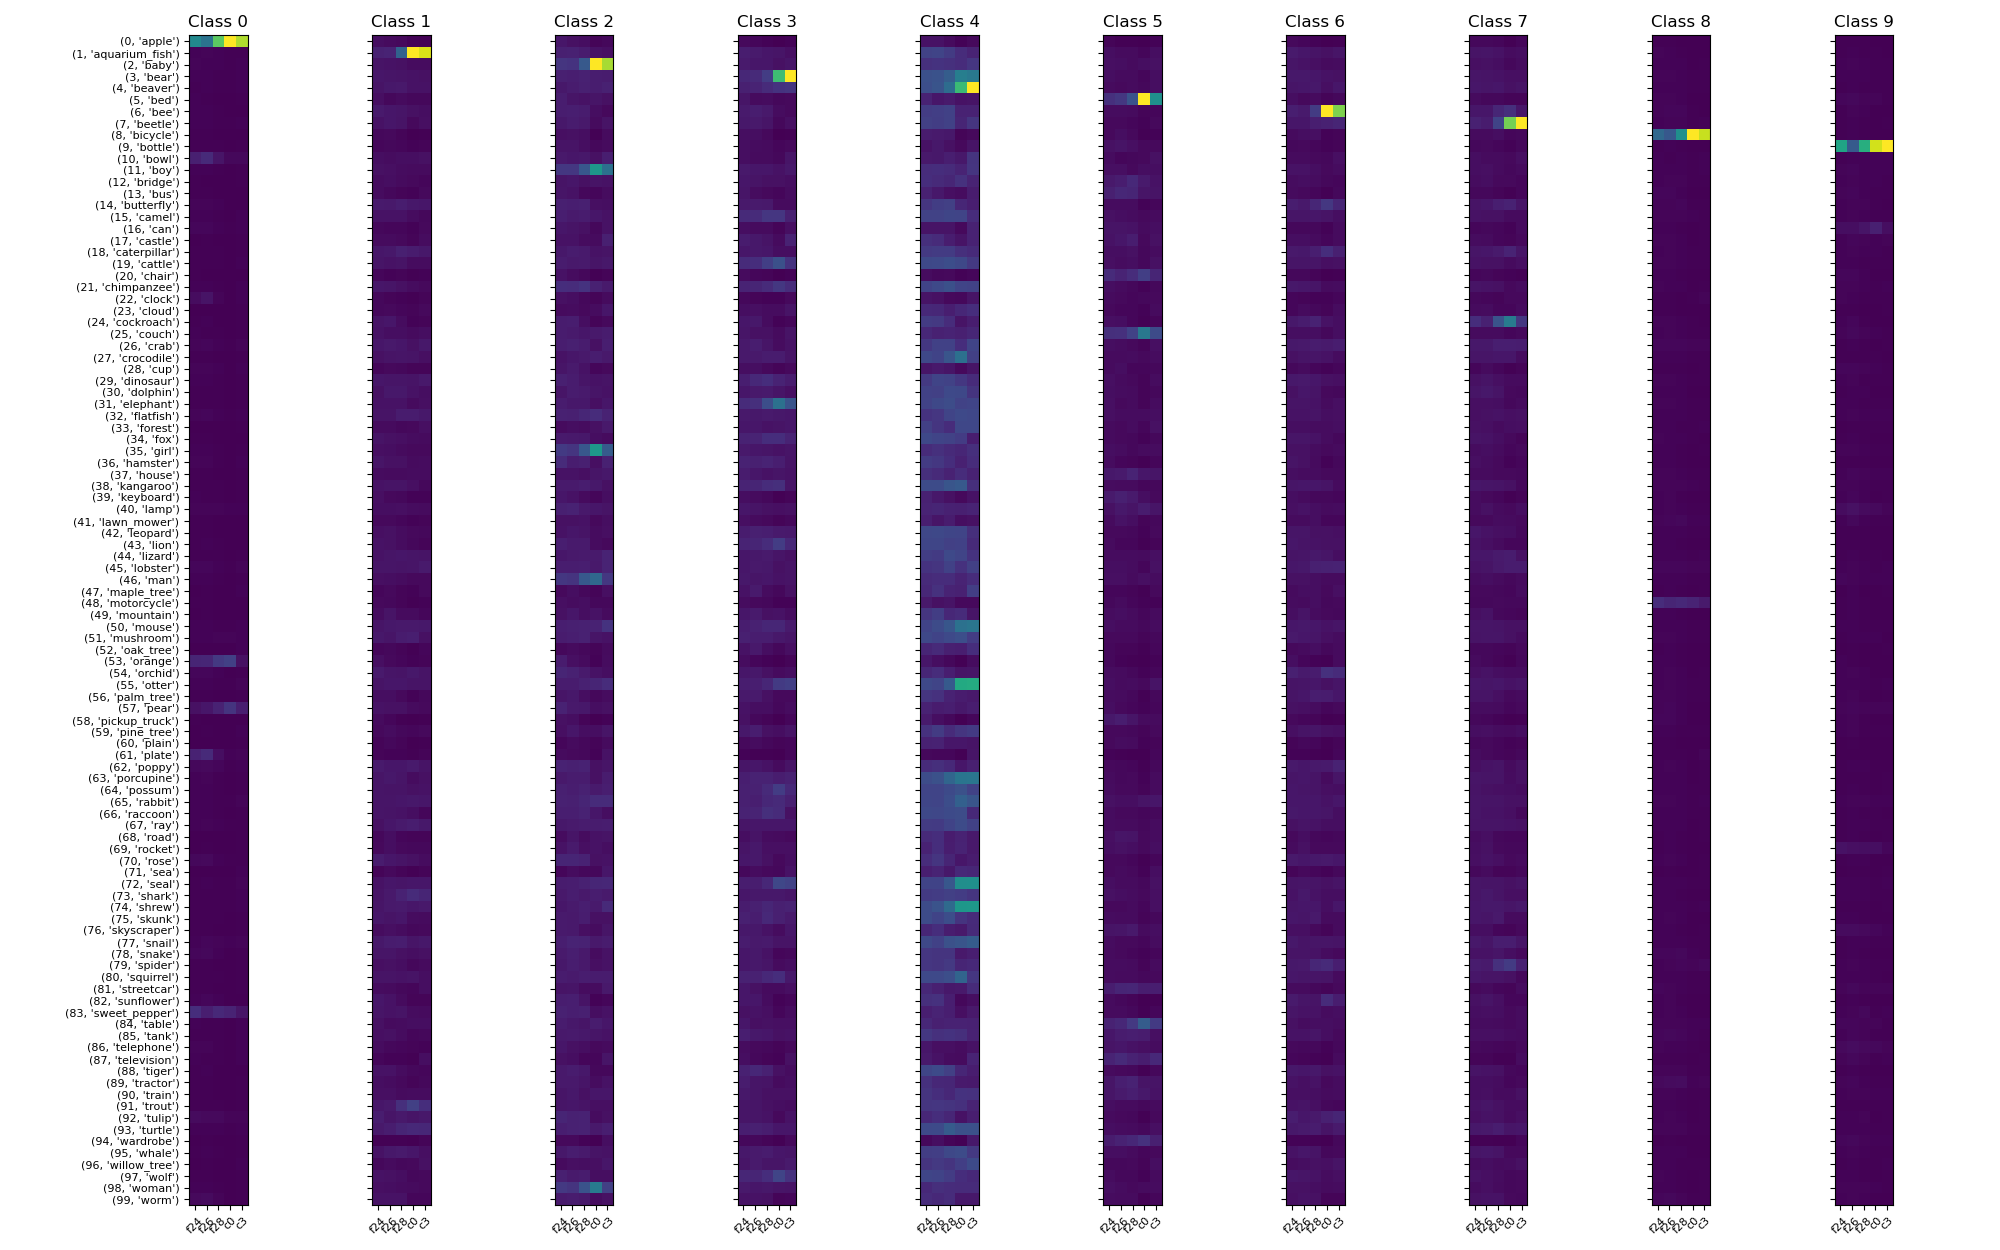

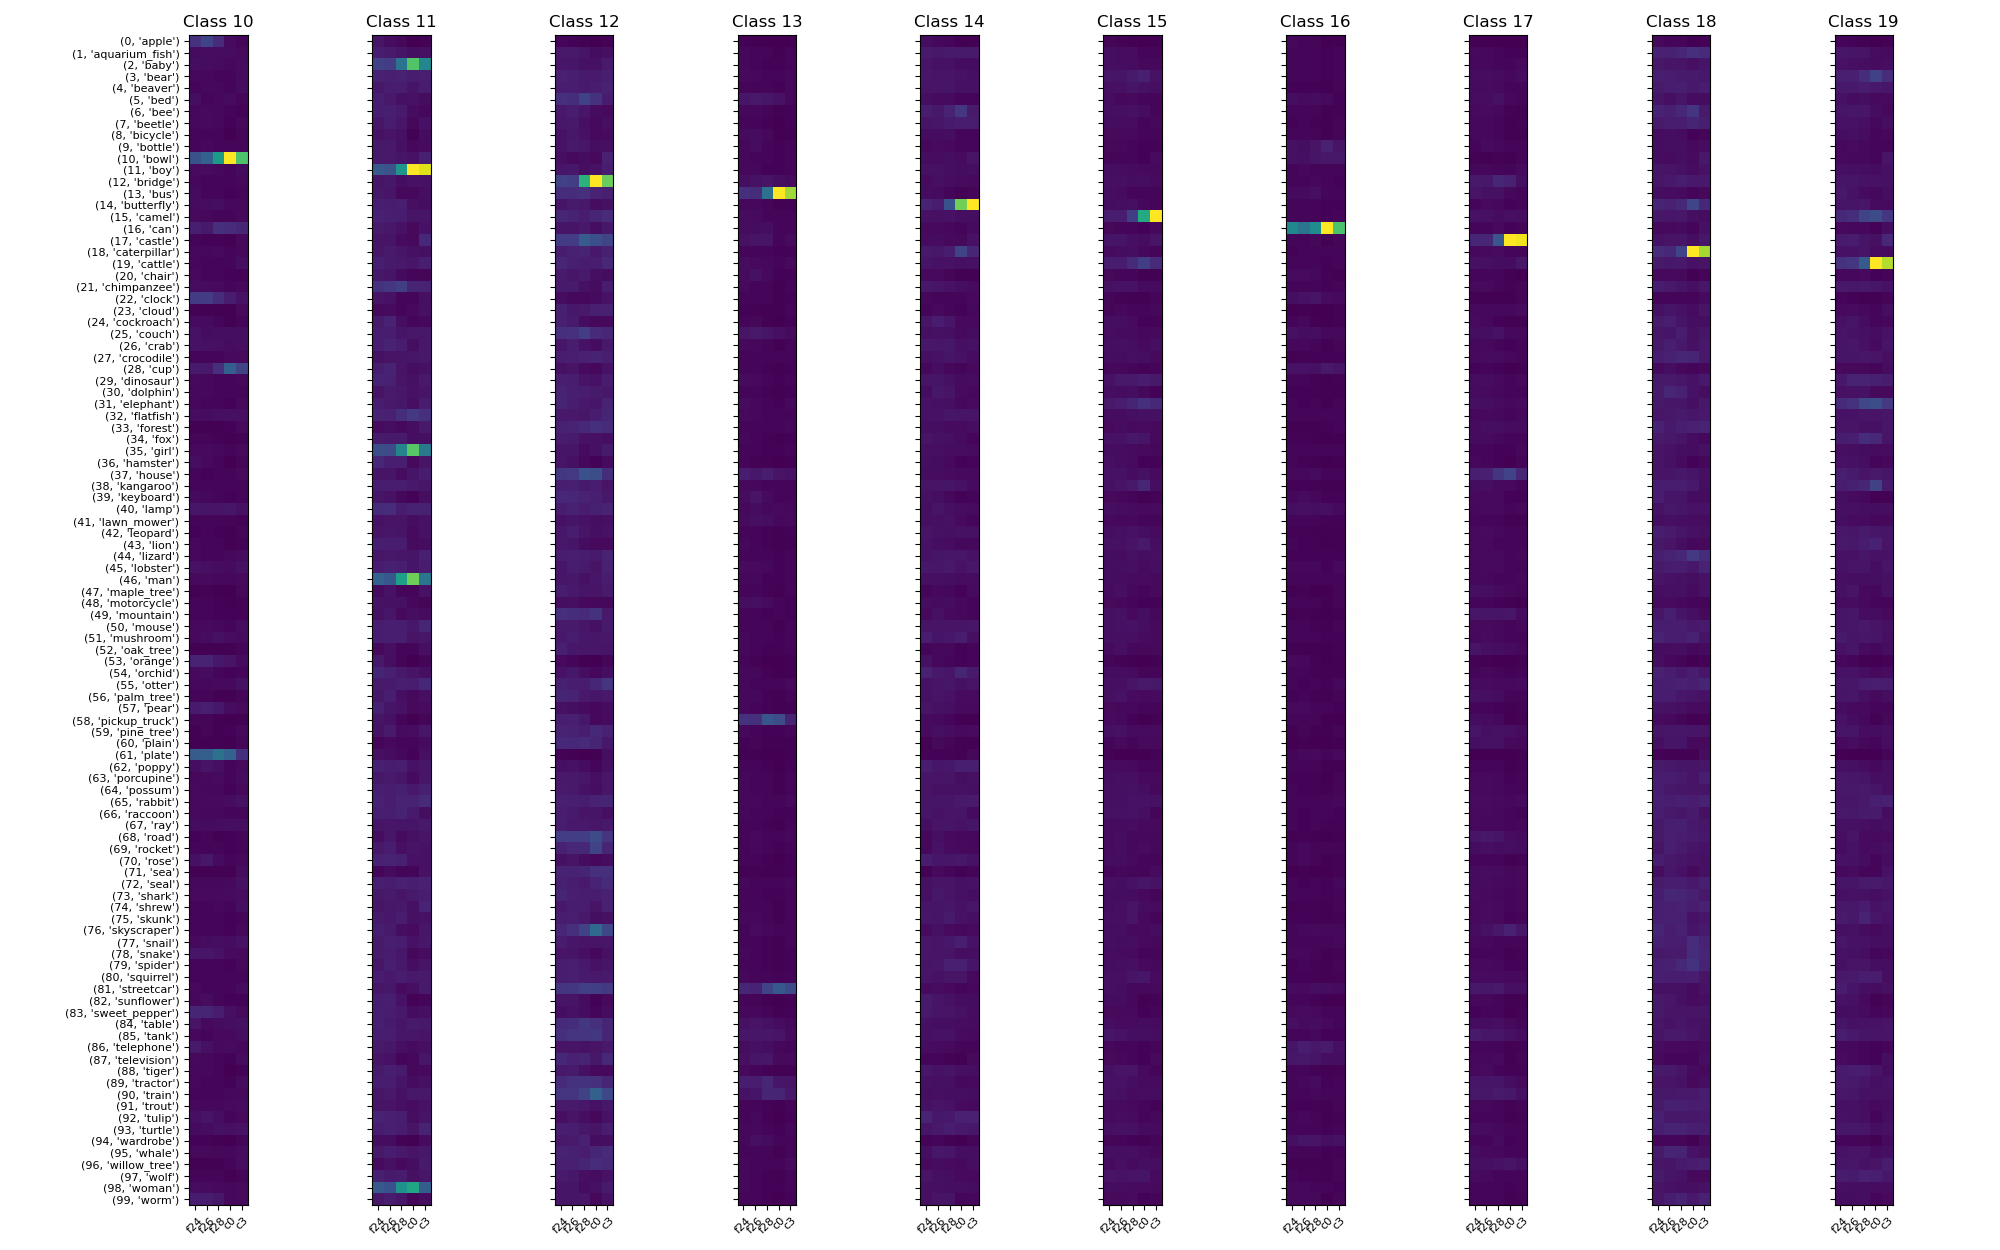

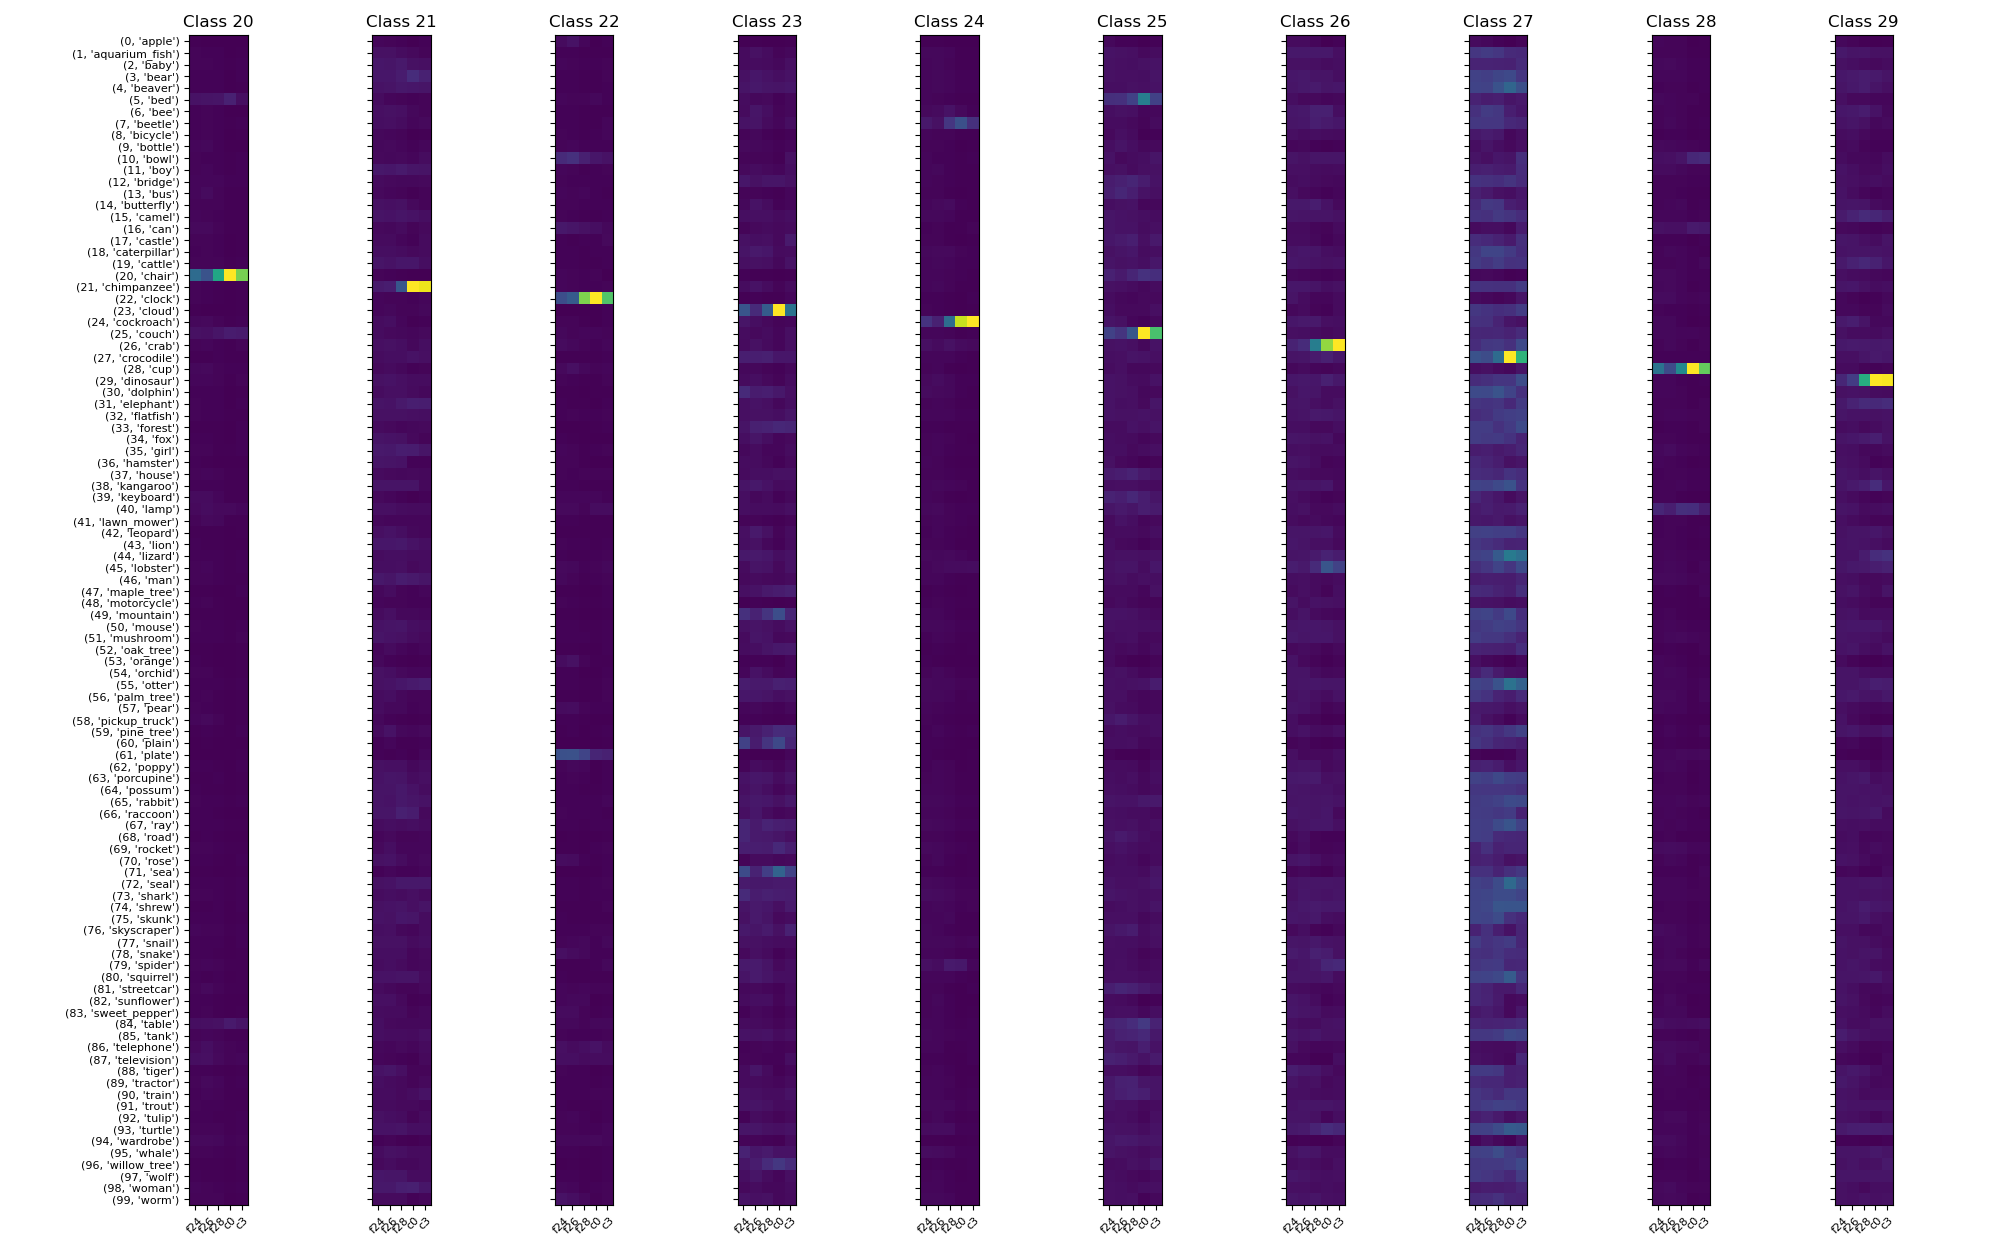

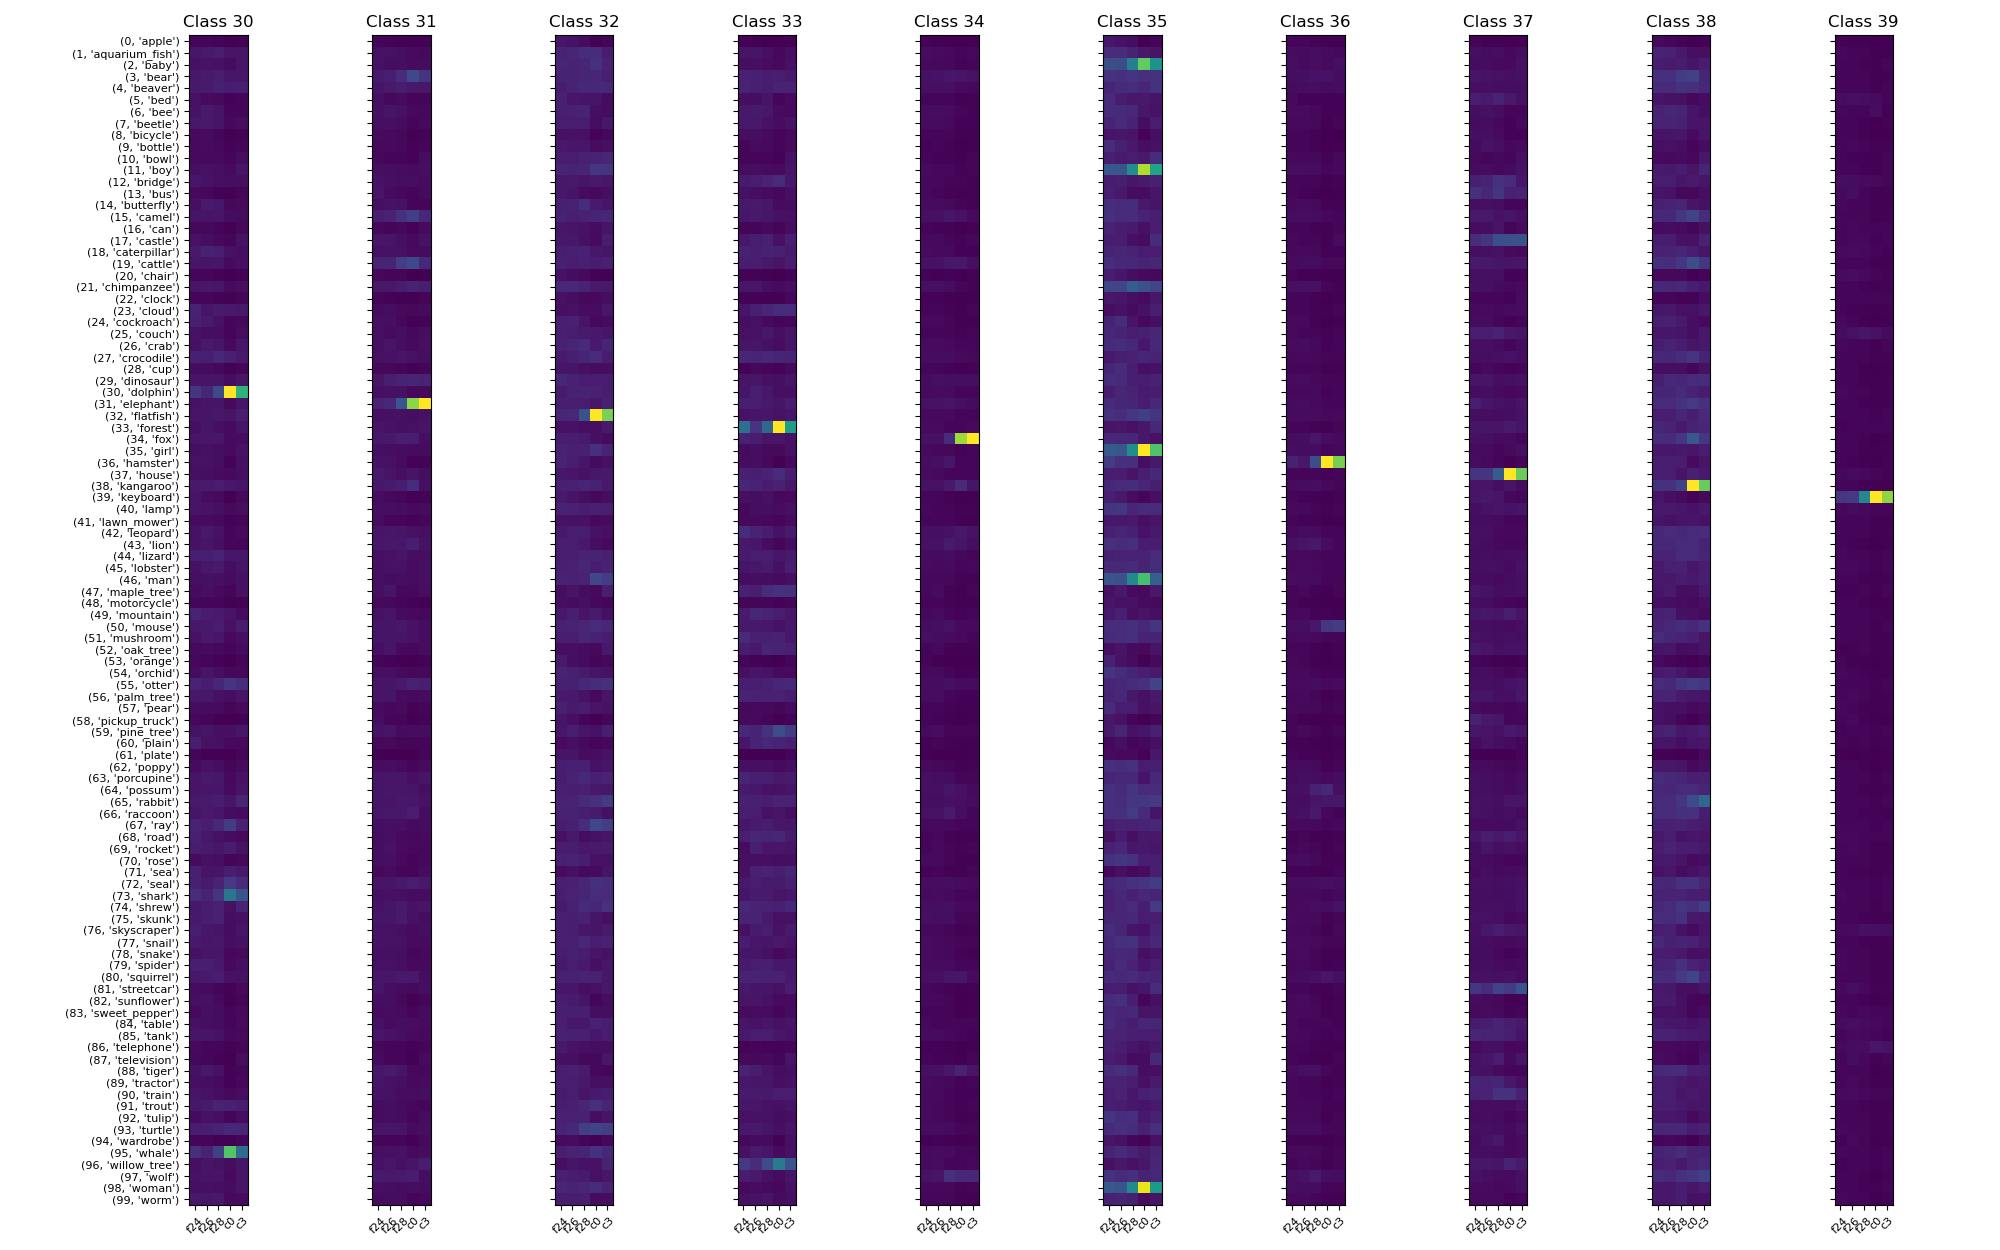

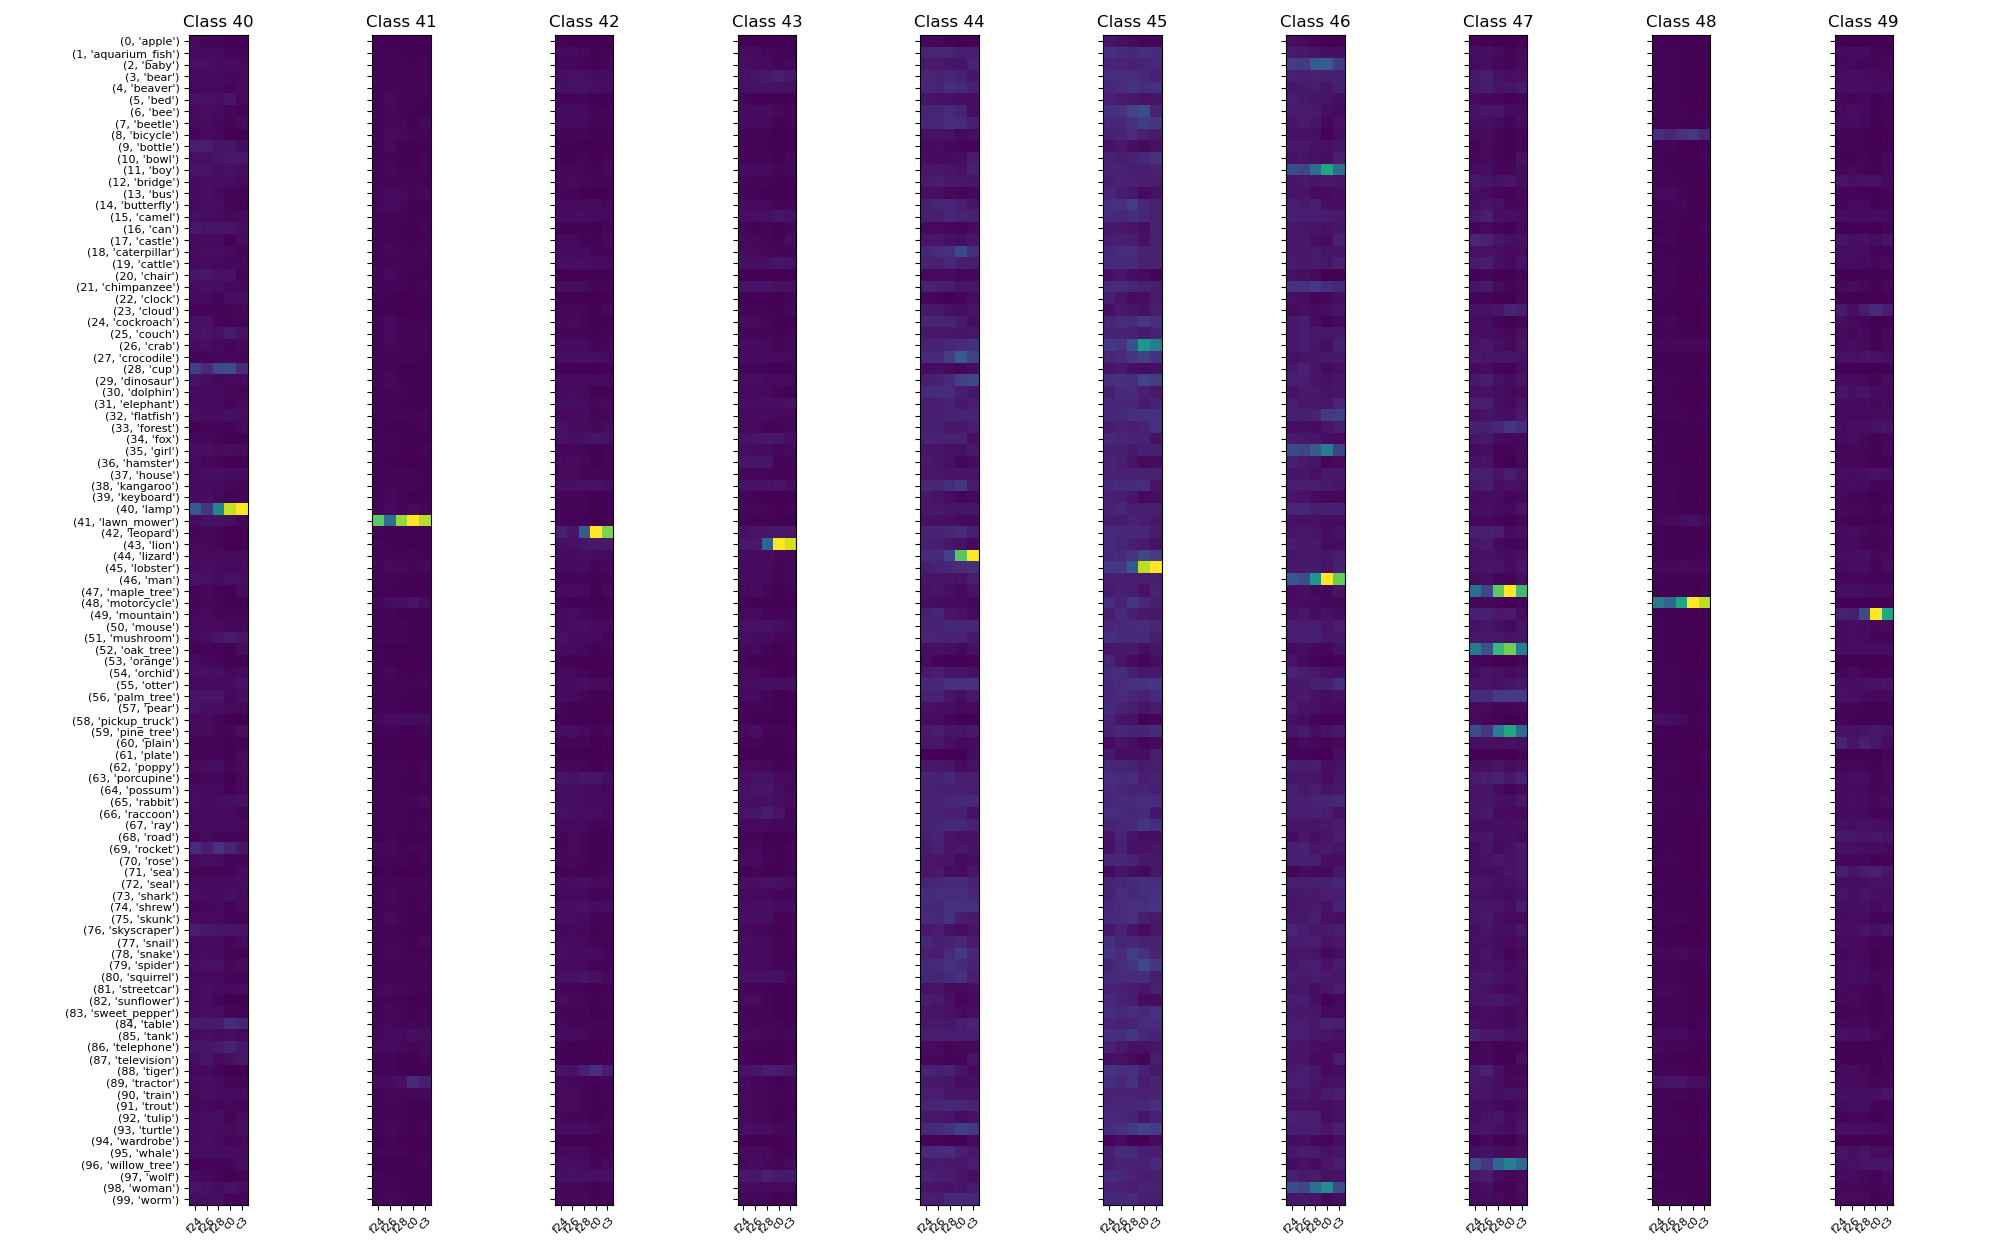

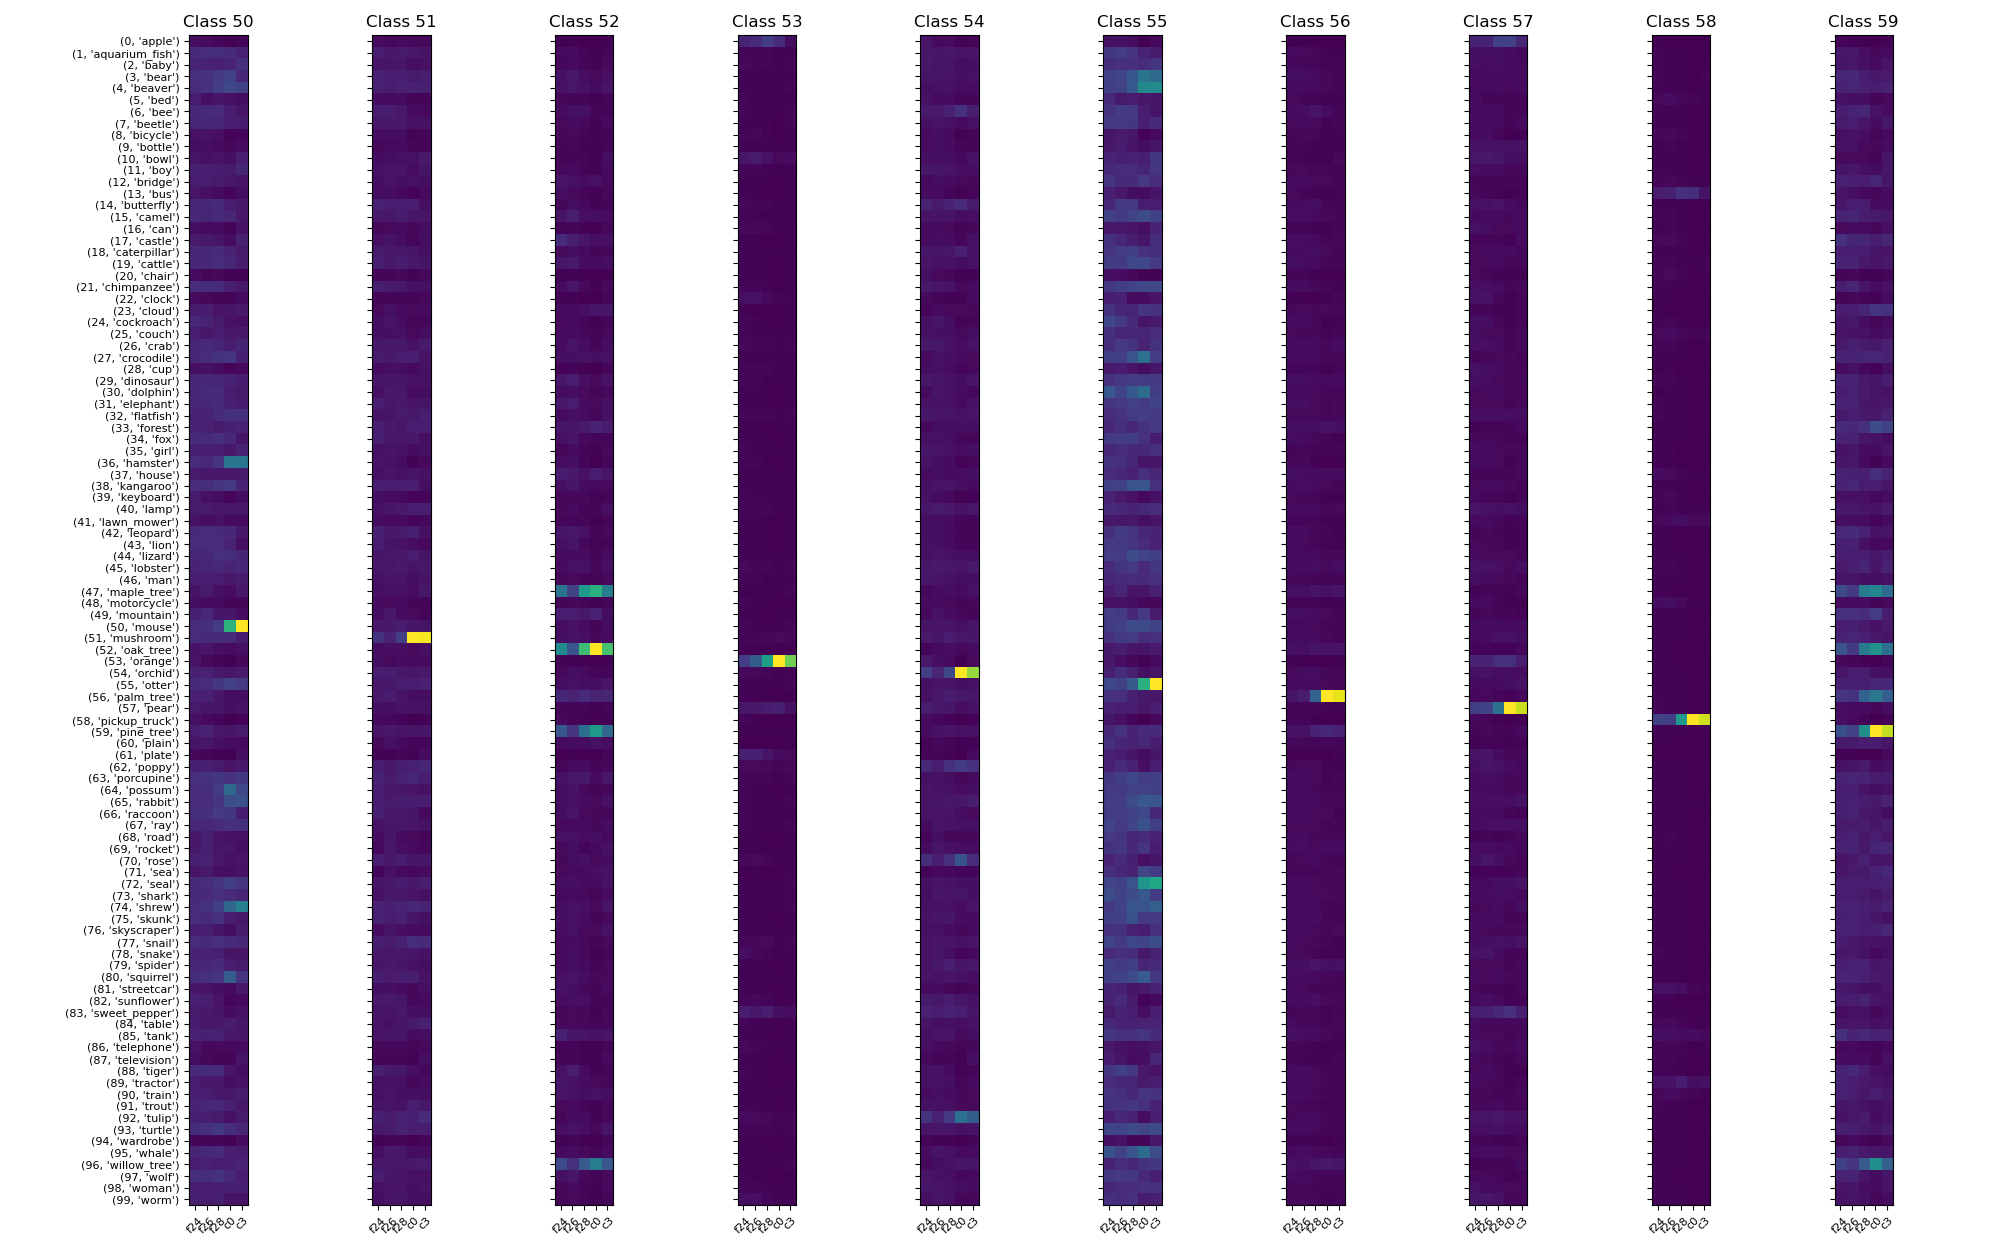

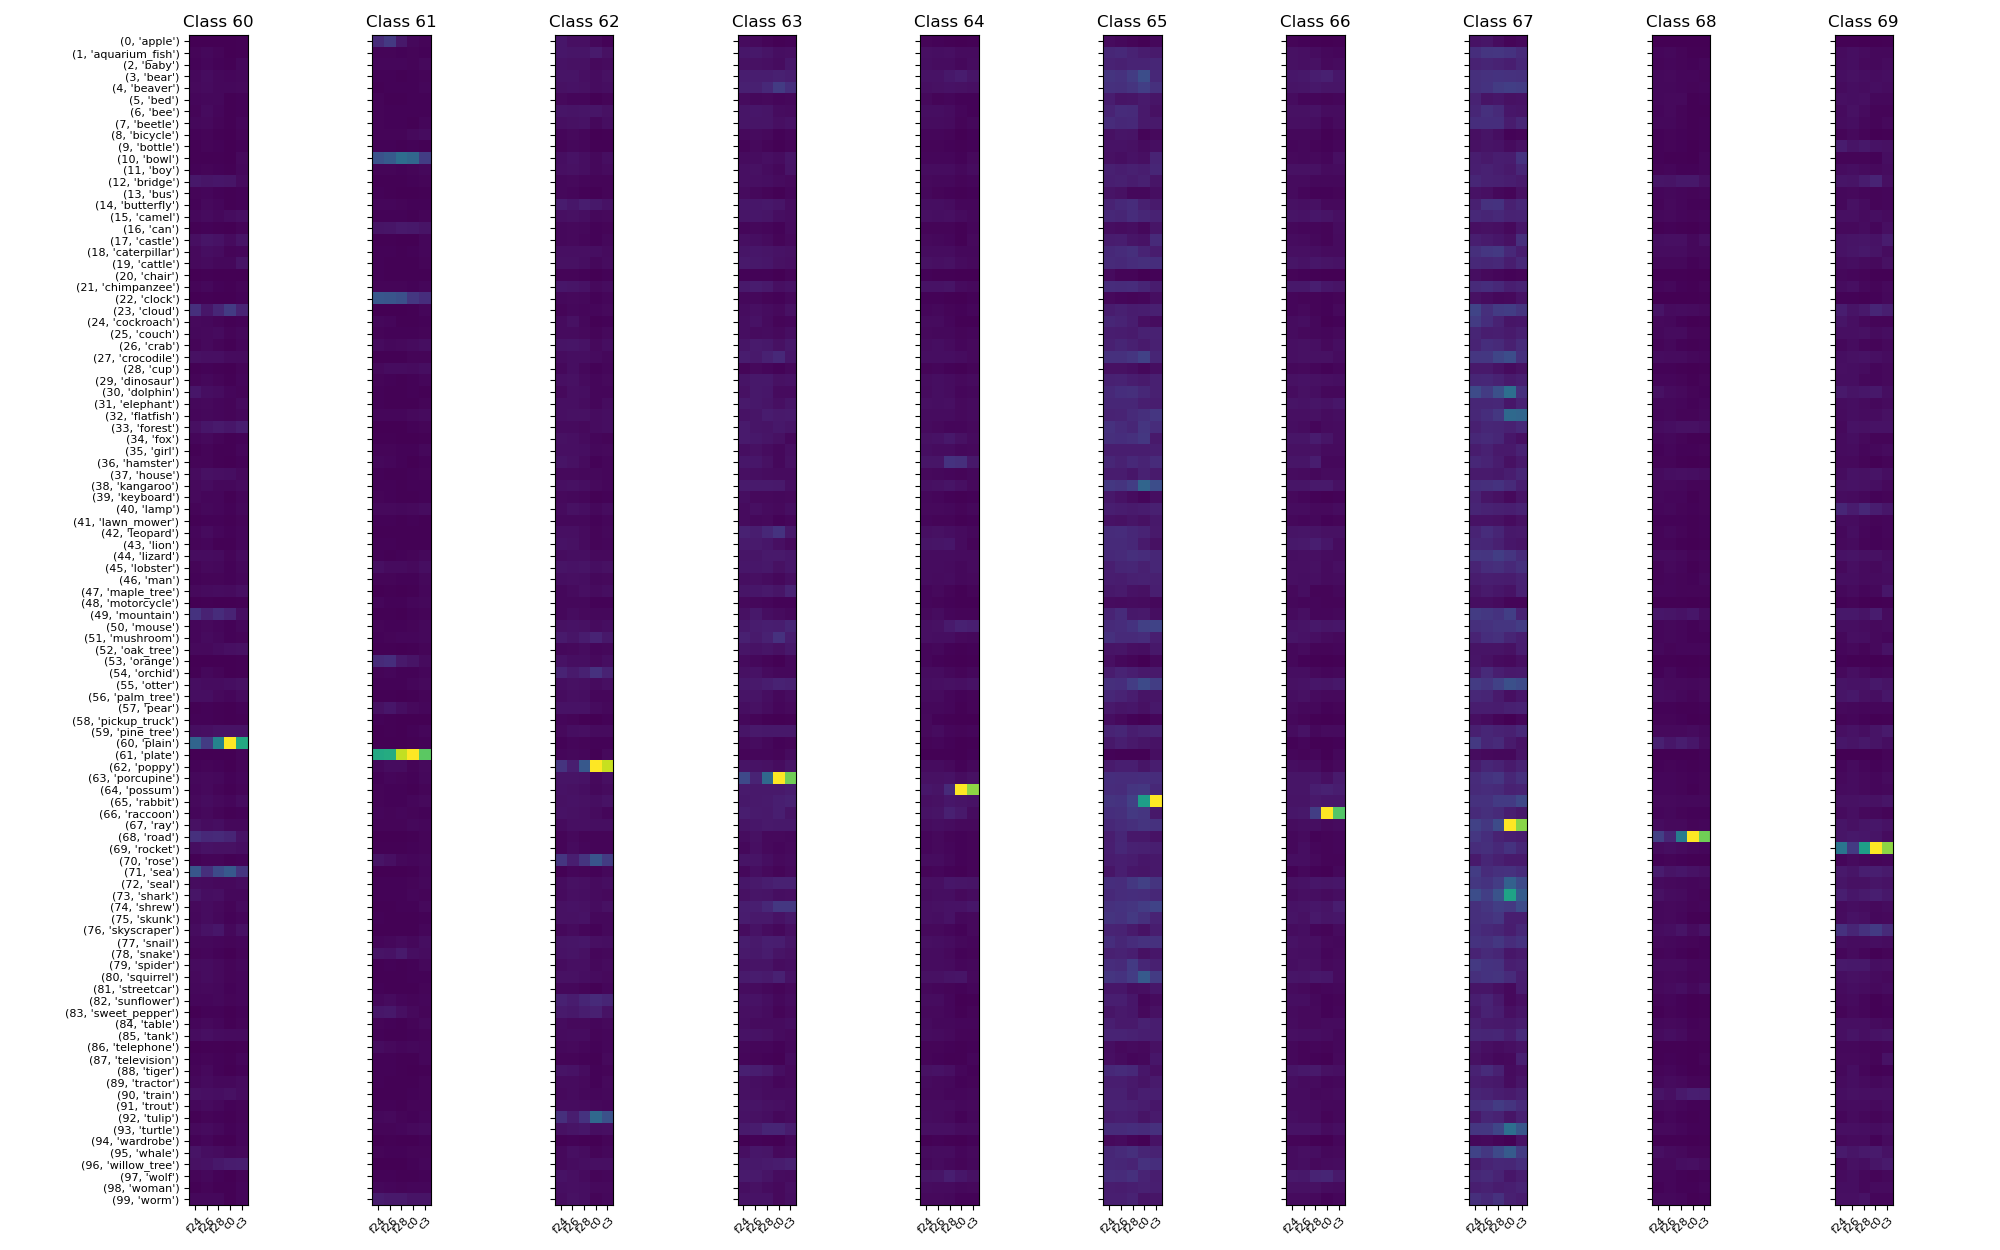

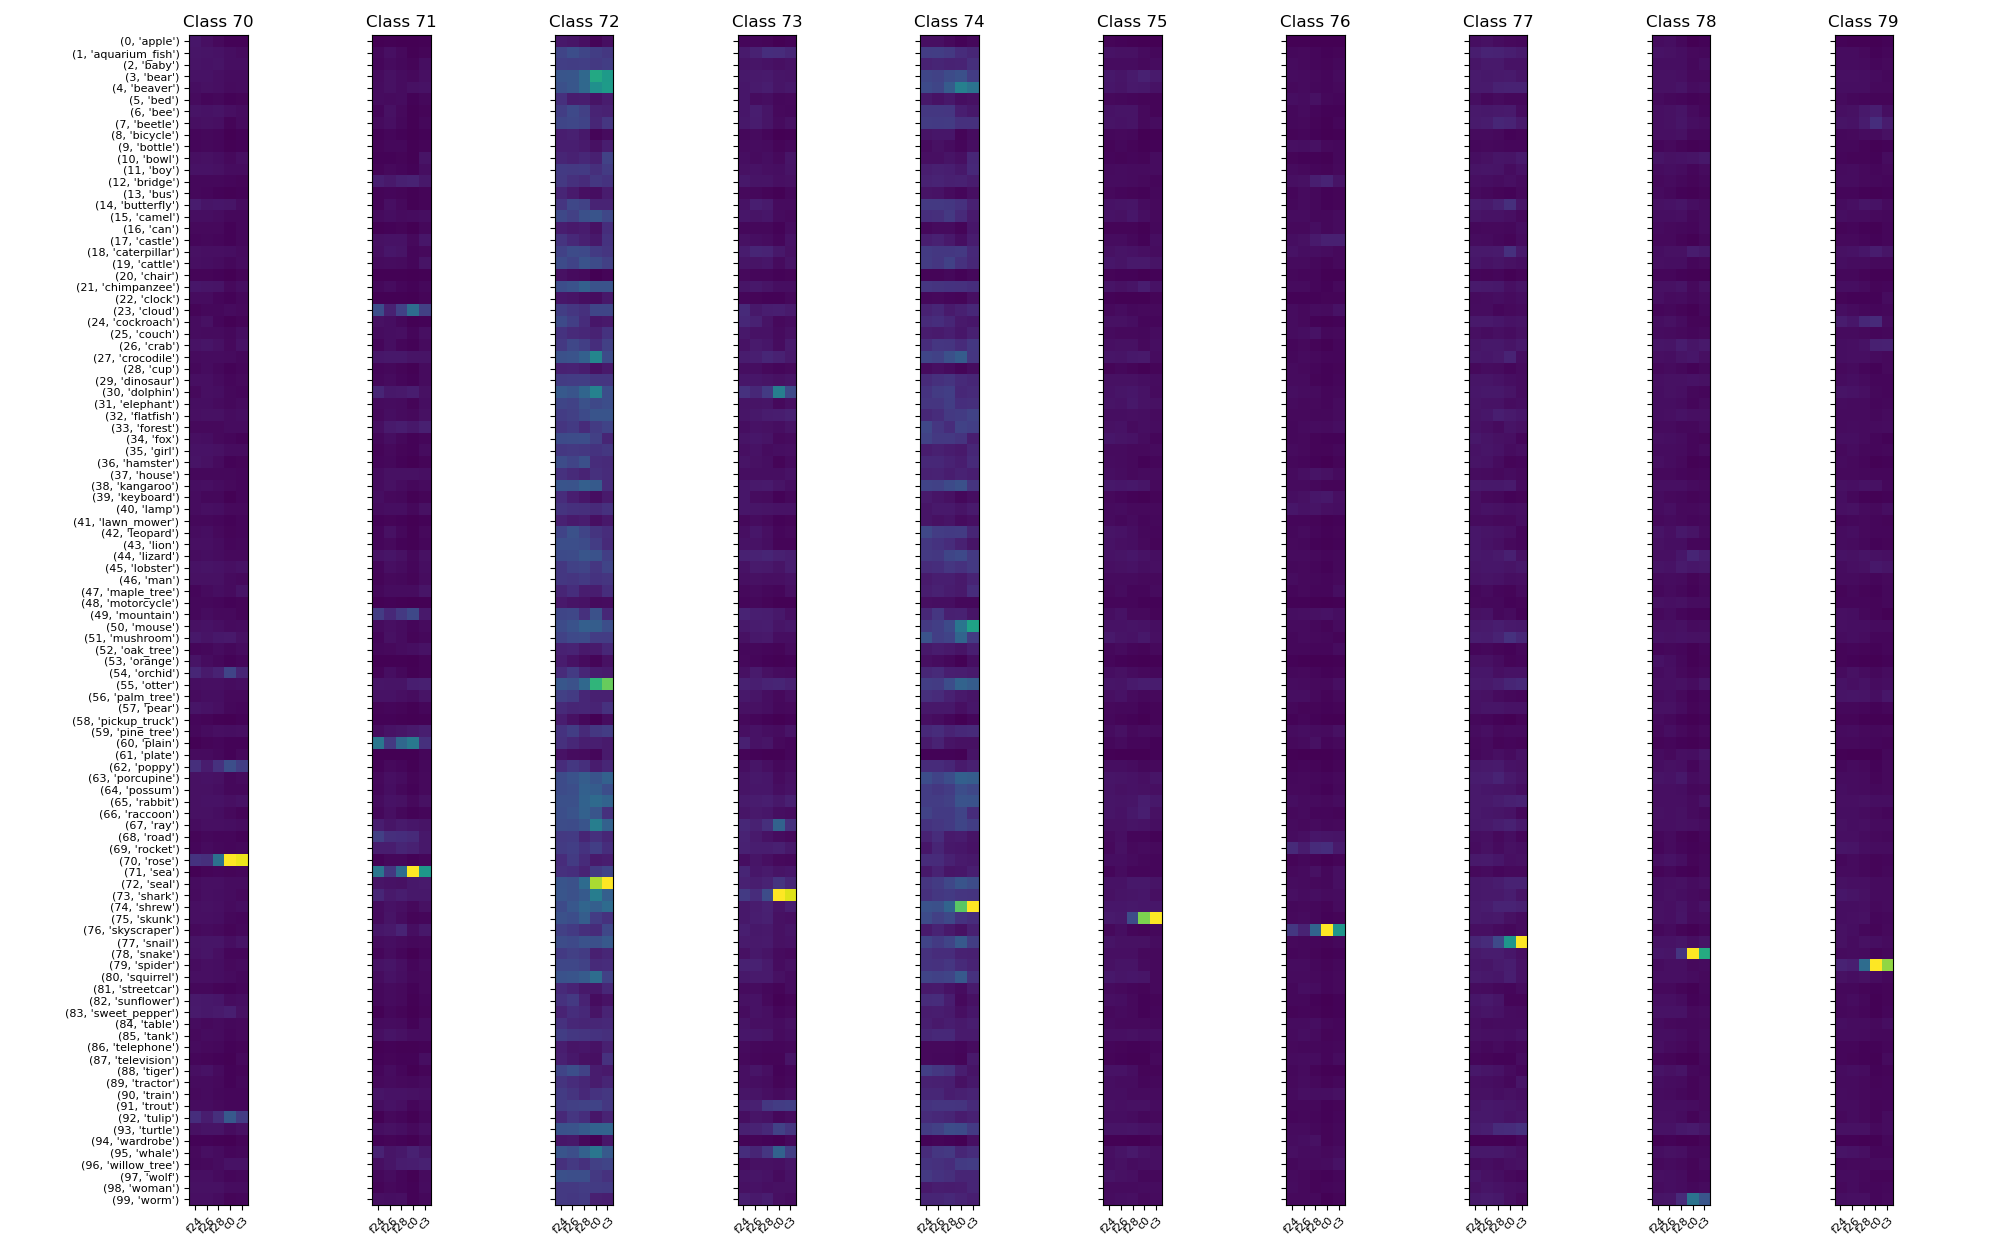

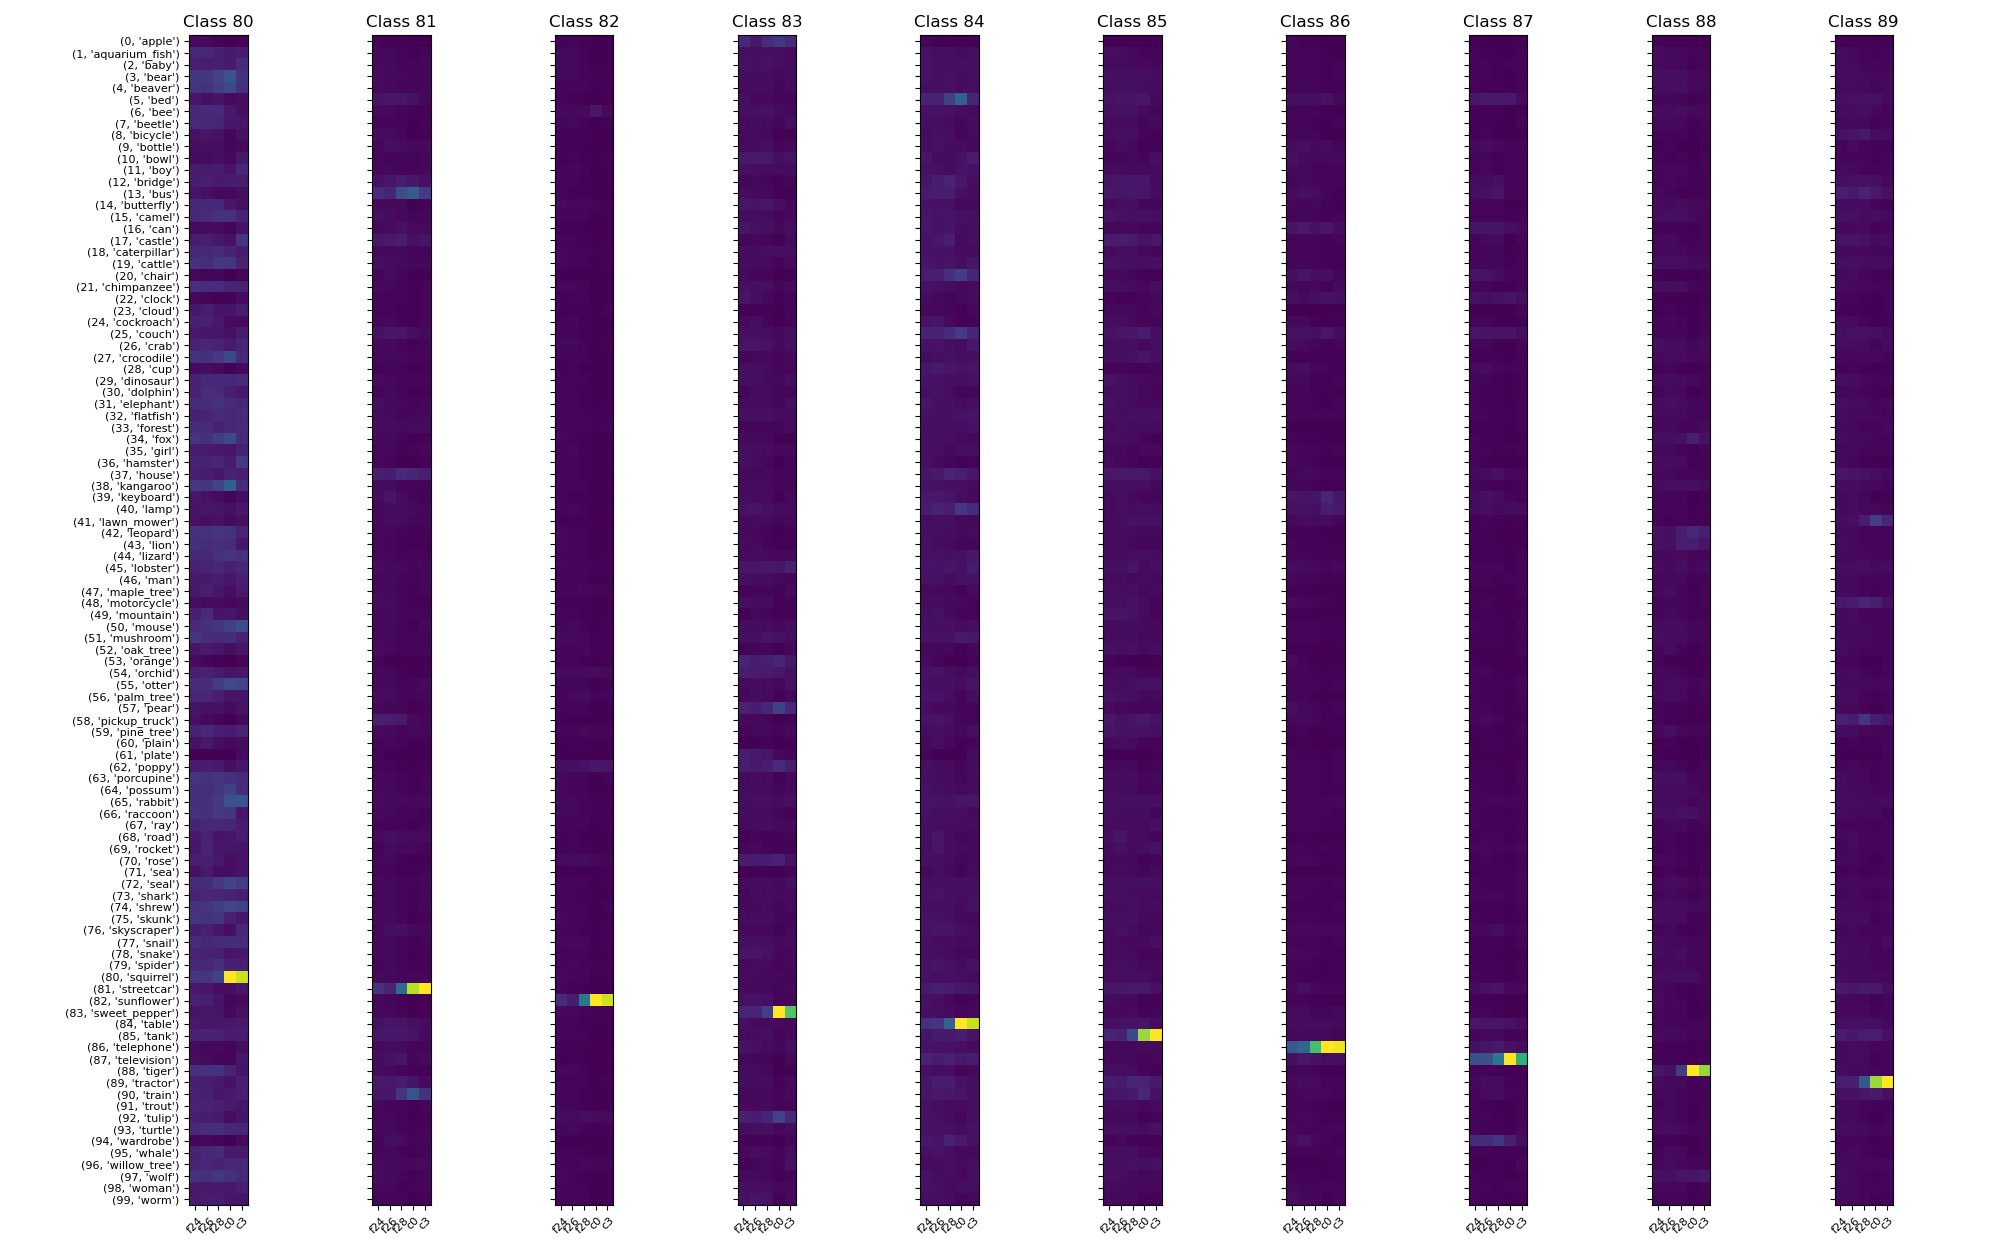

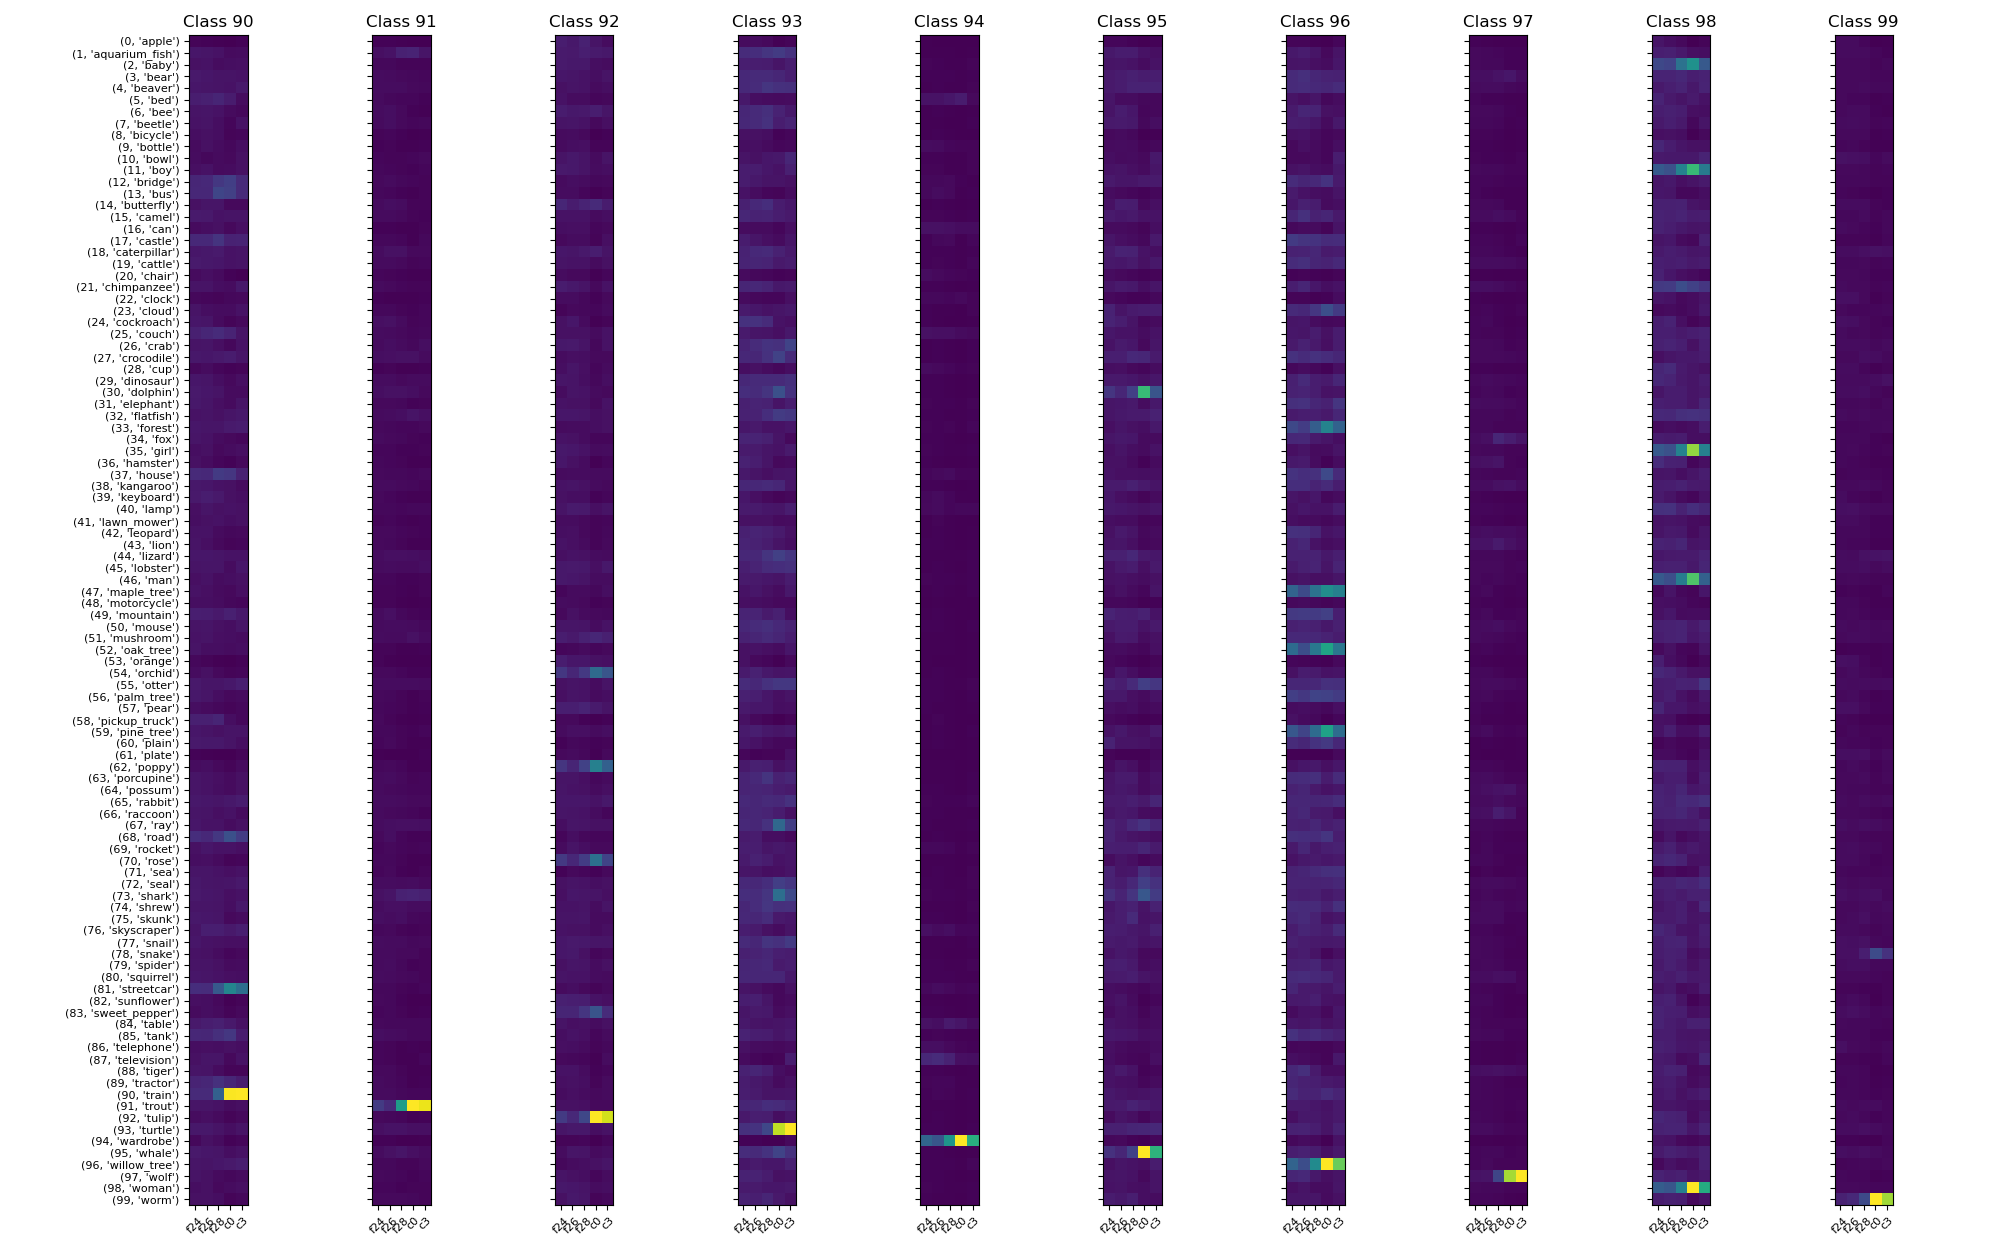

In [39]:
plt.close('all')
classes_per_fig = 10
n_figs = int(np.ceil(n_classes / classes_per_fig))

x_labels = ['f24', 'f26', 'f28', 'c0', 'c3']
y_labels = np.arange(n_classes)
class_labels = list(classes.values())

for fig_idx in range(n_figs):
    fig, axs = plt.subplots(1, classes_per_fig, figsize=(2*classes_per_fig, 2.5*n_layers), sharex=True, sharey=True)

    start_idx = fig_idx * classes_per_fig
    end_idx = min(start_idx + classes_per_fig, n_classes)
    
    for i, c in enumerate(range(start_idx, end_idx)):
        ax = axs[i] if classes_per_fig > 1 else axs
        ax.imshow(P[c])
        ax.set_title(f'Class {c}')
        #ax.axis('off')
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, fontsize=8, rotation=45)
        
        if i == 0:
            ax.set_yticks(y_labels)
            ax.set_yticklabels(classes.items(), fontsize=8)
    
    plt.tight_layout()
    plt.show()


__2. Measure Distance to Prototype__

In [43]:
from scipy.linalg import norm

def frobenius_distance(P_i, P_c):
    '''
    Computes the Frobenius norm (matrix distance) between two conceptograms.
    
    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - P_c: Prototype conceptogram (matrix of shape [n_classes, n_layers])
    
    Returns:
    - Frobenius distance (scalar)
    '''
    return norm(P_i - P_c, 'fro')

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_distance(P_i, P_c):
    '''
    Computes the cosine distance between two conceptograms after flattening them into 1D vectors.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - P_c: Prototype conceptogram (matrix of shape [n_classes, n_layers])

    Returns:
    - Cosine distance (scalar, range: [0, 2], where 0 = most similar, 2 = most different)
    '''
    P_i_flat = P_i.flatten().reshape(1, -1)  # flatten and reshape for sklearn function
    P_c_flat = P_c.flatten().reshape(1, -1)
    
    cos_sim = cosine_similarity(P_i_flat, P_c_flat)[0, 0]  # compute cosine similarity
    return 1 - cos_sim  # convert to distance (0 = identical, 2 = completely opposite)

In [41]:
from scipy.spatial.distance import mahalanobis

def mahalanobis_distance(P_i, P_c, inv_cov_matrix):
    '''
    Computes the Mahalanobis distance between two conceptograms.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - P_c: Prototype conceptogram (matrix of shape [n_classes, n_layers])
    - inv_cov_matrix: Precomputed inverse covariance matrix (shape: [(n_classes * n_layers), (n_classes * n_layers)])

    Returns:
    - Mahalanobis distance (scalar)
    '''
    P_i_flat = P_i.flatten()
    P_c_flat = P_c.flatten()
    return mahalanobis(P_i_flat, P_c_flat, inv_cov_matrix)

In [42]:
def compute_inverse_cov_matrix(conceptograms):
    '''
    Computes the inverse covariance matrix for a dataset of conceptograms.

    Parameters:
    - conceptograms: List or array of conceptograms (each with shape [n_classes, n_layers])

    Returns:
    - Inverse covariance matrix (shape: [(n_classes * n_layers), (n_classes * n_layers)])
    '''
    conceptograms_flat = np.array([P.flatten() for P in conceptograms])  # Flatten each conceptogram
    cov_matrix = np.cov(conceptograms_flat, rowvar=False)  # Compute covariance
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Compute pseudo-inverse (to avoid singularity issues)
    return inv_cov_matrix

In [ ]:
# distance to the prototype of the predicted class

__3. Normalization and Confidence Score__

##### Measures on a Distance Vector

__Idea:__ \

| **Metric**               | **Formula**                                       | **Lower Values Interpretation** | **Higher Values Interpretation** |
|--------------------------|--------------------------------------------------|--------------------------------|--------------------------------|
| **Distance to Prototype** | $ d(P_i, \bar{P}_{pred}) $  | Higher confidence, sample is close to its predicted class prototype. | More uncertainty, sample is farther from the predicted class prototype. |
| **Distance Entropy** | $ H(D) = -\sum_{c} p_c \log p_c $, where $ p_c = \frac{\exp(-d(P_i, \bar{P}_c))}{\sum_{c'} \exp(-d(P_i, \bar{P}_{c'}) )} $  | One class is dominant → Model is **confident**. | Distances are spread out → Model is **confused**. |
| **Confidence Margin** | $ \text{Margin} = d(P_i, \bar{P}_2) - d(P_i, \bar{P}_1) $  | Small margin → Model is uncertain (class overlap). | Large margin → Model is confident (clear separation). |
| **Trust Score** | $ \frac{d(P_i, \bar{P}_1)}{\frac{1}{N_C} \sum_{c=1}^{N_C} d(P_i, \bar{P}_c)} $ | High confidence (predicted class is much closer than the rest). | Uncertainty (sample is not clearly associated with any class). |
| **Softmax Over Distances** | $ p_{\text{predicted}} = \frac{\exp(-d(P_i, \bar{P}_{pred}))}{\sum_c \exp(-d(P_i, \bar{P}_c))} $ | Model is sure about its decision (**0.9 - 1.0**). | Potential ambiguity in classification (**0.5 - 0.7**). |


In [52]:
import numpy as np
from scipy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import mahalanobis
from scipy.stats import entropy

def compute_distance_vector(P_i, prototypes, distance_type='frobenius', inv_cov_matrix=None):
    '''
    Computes a distance vector from a sample conceptogram P_i to all class prototypes.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - prototypes: Dictionary of class prototypes {class_index: conceptogram matrix}
    - distance_type: Type of distance to compute ('frobenius', 'cosine', 'mahalanobis')
    - inv_cov_matrix: Inverse covariance matrix required for Mahalanobis distance (if needed)

    Returns:
    - distances: A numpy array of distances to all prototypes
    '''
    distances = []
    
    for c in range(len(prototypes)):
        P_c = prototypes[c]

        if distance_type == 'frobenius':
            d = norm(P_i - P_c, 'fro')

        elif distance_type == 'cosine':
            P_i_flat = P_i.flatten().reshape(1, -1)
            P_c_flat = P_c.flatten().reshape(1, -1)
            cos_sim = cosine_similarity(P_i_flat, P_c_flat)[0, 0]
            d = 1 - cos_sim  # Convert to distance

        elif distance_type == 'mahalanobis':
            if inv_cov_matrix is None:
                raise ValueError('Mahalanobis distance requires an inverse covariance matrix.')
            P_i_flat = P_i.flatten()
            P_c_flat = P_c.flatten()
            d = mahalanobis(P_i_flat, P_c_flat, inv_cov_matrix)

        else:
            raise ValueError("Invalid distance type. Choose from 'frobenius', 'cosine', 'mahalanobis'.")

        distances.append(d)
    
    return np.array(distances)

def distance_to_probabilities(distances):
    '''
    Converts a distance vector into a probability-like distribution using a softmax transformation.

    Parameters:
    - distances: Numpy array of distances

    Returns:
    - p_c: Probability-like vector (normalized)
    '''
    exp_distances = np.exp(-distances)  # apply negative exponent to convert to similarity
    p_c = exp_distances / np.sum(exp_distances)  # normalize
    return p_c

def compute_distance_entropy(P_i, prototypes, distance_type='frobenius', inv_cov_matrix=None):
    '''
    Computes the entropy of a distance-based probability distribution.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - prototypes: Dictionary of class prototypes {class_index: conceptogram matrix}
    - distance_type: Type of distance to use ('frobenius', 'cosine', 'mahalanobis')
    - inv_cov_matrix: Inverse covariance matrix required for Mahalanobis distance (if needed)

    Returns:
    - entropy_value: Entropy of the probability-like vector
    '''
    distances = compute_distance_vector(P_i, prototypes, distance_type, inv_cov_matrix)
    p_c = distance_to_probabilities(distances)
    return entropy(p_c)

def compute_inverse_cov_matrix(conceptograms):
    '''
    Computes the inverse covariance matrix for a dataset of conceptograms.

    Parameters:
    - conceptograms: List or array of conceptograms (each with shape [n_classes, n_layers])

    Returns:
    - Inverse covariance matrix (shape: [(n_classes * n_layers), (n_classes * n_layers)])
    '''
    conceptograms_flat = np.array([P.flatten() for P in conceptograms])  # flatten each conceptogram
    cov_matrix = np.cov(conceptograms_flat, rowvar=False)  # compute covariance
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # compute pseudo-inverse (to avoid singularity issues)
    return inv_cov_matrix

In [50]:
def compute_margin(P_i, prototypes, distance_type='frobenius', inv_cov_matrix=None):
    '''
    Computes the margin between the closest and second-closest class prototypes.
    
    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - prototypes: Dictionary of class prototypes {class_index: conceptogram matrix}
    - distance_type: Type of distance to compute ('frobenius', 'cosine', 'mahalanobis')
    - inv_cov_matrix: Inverse covariance matrix for Mahalanobis distance (if needed)
    
    Returns:
    - Margin: Difference between the second-smallest and smallest distance
    '''
    distances = compute_distance_vector(P_i, prototypes, distance_type, inv_cov_matrix)
    sorted_distances = np.sort(distances)
    return sorted_distances[1] - sorted_distances[0]  # second-smallest - smallest


def compute_trust_score(P_i, prototypes, distance_type='frobenius', inv_cov_matrix=None):
    '''
    Computes the trust score as the ratio between the closest class distance and the average distance.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - prototypes: Dictionary of class prototypes {class_index: conceptogram matrix}
    - distance_type: Type of distance to compute ('frobenius', 'cosine', 'mahalanobis')
    - inv_cov_matrix: Inverse covariance matrix for Mahalanobis distance (if needed)

    Returns:
    - Trust Score: Ratio between the smallest distance and the average distance
    '''
    distances = compute_distance_vector(P_i, prototypes, distance_type, inv_cov_matrix)
    min_distance = np.min(distances)
    avg_distance = np.mean(distances)
    return min_distance / avg_distance


def compute_softmax_confidence(P_i, prototypes, predicted_class, distance_type='frobenius', inv_cov_matrix=None):
    '''
    Computes a softmax-based confidence score using distances to all class prototypes.

    Parameters:
    - P_i: Sample conceptogram (matrix of shape [n_classes, n_layers])
    - prototypes: Dictionary of class prototypes {class_index: conceptogram matrix}
    - predicted_class: The class predicted by the DNN
    - distance_type: Type of distance to compute ('frobenius', 'cosine', 'mahalanobis')
    - inv_cov_matrix: Inverse covariance matrix for Mahalanobis distance (if needed)

    Returns:
    - Softmax confidence for the predicted class
    '''
    distances = compute_distance_vector(P_i, prototypes, distance_type, inv_cov_matrix)
    exp_distances = np.exp(-distances)
    softmax_probs = exp_distances / np.sum(exp_distances)
    return softmax_probs[predicted_class]


###### a. Measure of confusion: Entropy

In [45]:
i = 5
P_ = cgs['test'][i]
pl = o_dnn_dfs['test'].loc[i, 'label']
tl = o_dnn_dfs['test'].loc[i, 'true']
c_dnn = o_dnn_dfs['test'].loc[i, 'max']

o_dnn_dfs['test'].iloc[i]

max        0.998854
entropy    0.997888
label            54
true             92
result        False
Name: 5, dtype: object

In [46]:
# compute inverse covariance matrix for Mahalanobis distance
conceptograms_dataset = list(P.values()) # assuming here just the prototypes to be representative
inv_cov_matrix = compute_inverse_cov_matrix(conceptograms_dataset)

distances_fro = np.array([frobenius_distance(P_, P[c]) for c in range(n_classes)])
distances_cos = np.array([cosine_distance(P_, P[c]) for c in range(n_classes)])
distances_mah = np.array([mahalanobis_distance(P_, P[c], inv_cov_matrix) for c in range(n_classes)])

print(f'Pred label: {pl}, True label: {tl}, DNN confidence: {c_dnn}\n')
print(f'Frobenius Distances to Prototypes: {distances_fro}\n \nmin_val: {np.min(distances_fro)}, pos: {np.argmin(distances_fro)}\n')
print(f'Cosine Distances to Prototypes: {distances_cos}\n \nmin_val: {np.min(distances_cos)}, pos: {np.argmin(distances_cos)}\n')
print(f'Mahalanobis Distances to Prototypes: {distances_mah}\n \nmin_val: {np.min(distances_mah)}, pos: {np.argmin(distances_mah)}\n')

Pred label: 54, True label: 92, DNN confidence: 0.9988536834716797

Frobenius Distances to Prototypes: [0.95000476 0.3281452  0.2777778  0.28622532 0.24009636 0.37181544
 0.22493316 0.32442296 0.96709746 0.94060934 0.43258885 0.3145389
 0.29317418 0.5662544  0.26503617 0.3764358  0.60349214 0.52640104
 0.2353994  0.33013278 0.8665774  0.39748633 0.7271546  0.354768
 0.73542315 0.32529932 0.3180295  0.24046786 0.6346479  0.35905242
 0.34078297 0.35078362 0.24631651 0.29969588 0.5268213  0.26594034
 0.52888066 0.36121014 0.26330212 0.7031012  0.36609057 0.7853619
 0.5313514  0.51271564 0.24690685 0.22536449 0.28253826 0.41037822
 0.8901373  0.44181898 0.24495114 0.29143348 0.4823182  0.7973525
 0.15475008 0.23478848 0.507243   0.43135178 1.0110989  0.3174924
 0.5136803  0.683531   0.3408197  0.3229452  0.44184268 0.23012047
 0.36654085 0.24351709 0.58562225 0.39250425 0.3596318  0.419573
 0.2342282  0.3175339  0.2412361  0.36733106 0.44397852 0.26777264
 0.37755635 0.3709058  0.25393686 

In [47]:
print(f'Pred label: {pl}, True label: {tl}, DNN confidence: {c_dnn}\n')

p_c = np.exp(-distances_fro) / np.sum(np.exp(-distances_fro))
print(f'Frobenius Distances to Prototypes: {p_c} \n\n max: {np.max(p_c)} pos: {np.argmax(p_c)}\n')
p_c = np.exp(-distances_cos) / np.sum(np.exp(-distances_cos))
print(f'Cosine Distances to Prototypes: {p_c} \n\n max: {np.max(p_c)} pos: {np.argmax(p_c)}\n')
p_c = np.exp(-distances_mah) / np.sum(np.exp(-distances_mah))
print(f'Mahalanobis Distances to Prototypes: {p_c} \n\n max: {np.max(p_c)} pos: {np.argmax(p_c)}\n')

Pred label: 54, True label: 92, DNN confidence: 0.9988536834716797

Frobenius Distances to Prototypes: [0.00587347 0.01093868 0.01150374 0.01140697 0.01194549 0.01047126
 0.012128   0.01097947 0.00577393 0.00592891 0.00985384 0.01108853
 0.01132798 0.00862095 0.01165126 0.01042299 0.00830583 0.00897147
 0.01200173 0.01091696 0.0063845  0.01020588 0.00733968 0.0106513
 0.00727924 0.01096985 0.01104989 0.01194105 0.00805105 0.01060576
 0.01080131 0.01069382 0.01187142 0.01125434 0.0089677  0.01164072
 0.00894925 0.0105829  0.01167148 0.00751837 0.01053138 0.00692465
 0.00892716 0.00909509 0.01186441 0.01212277 0.01144911 0.01007515
 0.00623584 0.00976331 0.01188764 0.01134772 0.0093758  0.00684212
 0.01300976 0.01200906 0.009145   0.00986604 0.00552538 0.01105583
 0.00908632 0.00766695 0.01080091 0.01099571 0.00976308 0.01206525
 0.01052664 0.0119047  0.00845559 0.01025685 0.01059962 0.00998293
 0.01201579 0.01105537 0.01193188 0.01051833 0.00974224 0.01161942
 0.01041132 0.01048079 0.01

In [ ]:
fig, axs = plt.subplots()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to plot one conceptogram visualization
def plot_conceptogram_comparison(P_i, prototypes, predicted_class, true_class, distance_type, inv_cov_matrix=None):
    '''
    Plots a candidate conceptogram, its predicted and true class prototypes,
    the distance vector, and its softmaxed version.

    Parameters:
    - P_i: Candidate conceptogram (n_classes x n_layers matrix)
    - prototypes: Dictionary {class_index: prototype conceptogram (n_classes x n_layers)}
    - predicted_class: Class predicted by the model
    - true_class: Ground truth class
    - distance_type: One of ['frobenius', 'cosine', 'mahalanobis']
    - inv_cov_matrix: Inverse covariance matrix for Mahalanobis distance (if applicable)
    '''
    n_classes, n_layers = P_i.shape

    # Compute distance vector
    distances = compute_distance_vector(P_i, prototypes, distance_type, inv_cov_matrix)
    softmax_distances = distance_to_probabilities(distances)  # Softmaxed distance vector

    # Set up subplots: 5 columns (Candidate, Pred Proto, True Proto, Distances, Softmaxed Distances)
    fig, axs = plt.subplots(1, 5, figsize=(14, 8), gridspec_kw={'width_ratios': [2, 2, 2, 1, 1]})
    
    # Titles
    titles = ['Candidate Conceptogram', 
              f'Predicted Prototype (Class {predicted_class})', 
              f'True Prototype (Class {true_class})', 
              'Distance Vector', 
              'Softmaxed Distances']
    
    # Plot candidate conceptogram
    sns.heatmap(P_i, ax=axs[0], cmap='coolwarm', cbar=False)
    
    # Plot predicted class prototype
    sns.heatmap(prototypes[predicted_class], ax=axs[1], cmap='coolwarm', cbar=False)
    
    # Plot true class prototype
    sns.heatmap(prototypes[true_class], ax=axs[2], cmap='coolwarm', cbar=False)
    
    # Plot distance vector as a column plot
    axs[3].barh(np.arange(n_classes), distances, color='purple', alpha=0.7)
    
    # Plot softmaxed distances
    axs[4].barh(np.arange(n_classes), softmax_distances, color='green', alpha=0.7)
    
    # Set subplot titles
    for ax, title in zip(axs, titles):
        ax.set_title(title, fontsize=10)

    # Remove y-axis labels except for rightmost plot
    for ax in axs[:-1]:
        ax.set_yticks([])
        ax.set_yticklabels([])

    # Highlight the predicted and true class labels on the rightmost plot
    y_labels = ["" for _ in range(n_classes)]
    y_labels[predicted_class] = f'Pred ({predicted_class})'
    y_labels[true_class] = f'True ({true_class})'
    axs[4].set_yticks(np.arange(n_classes))
    axs[4].set_yticklabels(y_labels, fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.suptitle(f"Conceptogram Comparison using {distance_type.capitalize()} Distance", fontsize=12, y=1.02)
    plt.show()

In [ ]:
n_classes = 10
n_layers = 5


P_i = P_
true_class = tl
predicted_class = pl

# Compute inverse covariance matrix for Mahalanobis
inv_cov_matrix = compute_inverse_cov_matrix(list(P.values()))

# === Generate Figures for Each Distance Type ===
for dist_type in ['frobenius', 'cosine', 'mahalanobis']:
    plot_conceptogram_comparison(P_, P, predicted_class, true_class, dist_type, inv_cov_matrix)

###### b. Confidence Gap: Margin between closest and second closest class

In [ ]:
margin_score = compute_margin(P_, P)
print('Confidence Margin:', margin_score)

###### c. Trust Score: Ratio between closest and average distance

In [ ]:
trust_score = compute_trust_score(P_, P)
print('Trust Score:', trust_score)

###### d. Alternative Confidence Measure: Softmax Over Distances
(Basically the intermediate step that leads to computing __.a__)

In [ ]:
softmax_confidence = compute_softmax_confidence(P_, P, predicted_class)
print('Softmax Confidence:', softmax_confidence)